## Import libraries

In [1]:
import gc
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()

In [2]:
plt.style.use('seaborn-poster')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

## Load source datasets

### District information data

#### Includes information about the characteristics of school districts, including data from **NCES (2018-19)**, **FCC (Dec 2018)**, and **Edunomics Lab**

| Name | Description |
| --- | --- |
|district_id | The unique identifier of the school district
|state | The state where the district resides in
|locale | NCES locale classification that categorizes U.S. territory into four types of areas: <br> 1) City <br> 2) Suburban <br> 3) Town <br> 4) Rural
|pct_black/hispanic | Percentage of students in the districts identified as Black or Hispanic
|pct_free/reduced | Percentage of students in the districts eligible for free or reduced-price lunch
|countyconnectionsratio | Ratio (residential fixed high-speed connections over 200 kbps in at least one direction/households)
|pptotalraw | Per-pupil total expenditure (sum of local and federal expenditure)

In [3]:
district_info_df = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv")
print(f"Number of samples: {district_info_df.shape[0]}")
district_info_df.head(10)

Number of samples: 233


,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN
5,5987,Wisconsin,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
6,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000["
7,7177,North Carolina,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[8000, 10000["
8,9812,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
9,6584,North Carolina,Rural,"[0.4, 0.6[","[0.6, 0.8[","[0.18, 1[","[8000, 10000["


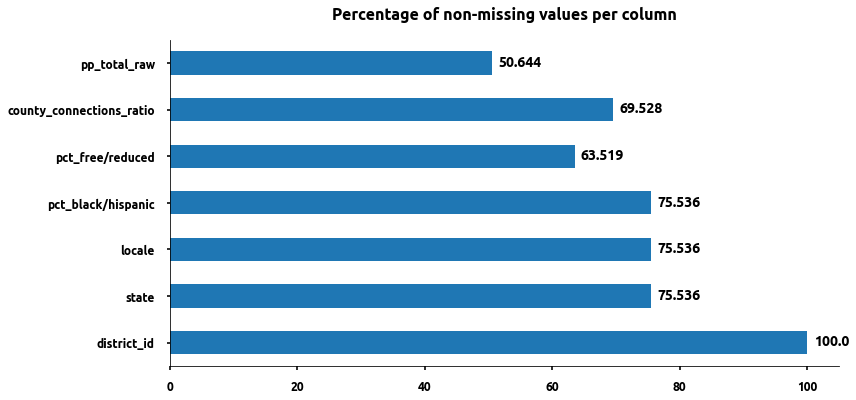

In [4]:
pct_df = pd.DataFrame(district_info_df.count() * 100 / len(district_info_df), 
                      columns=['Percent Non-Missing'])
pct_df['Percent Non-Missing'] = np.round(pct_df['Percent Non-Missing'], 3)

pct_df.plot(kind='barh', figsize=(12, 6), legend=False)
plt.title("Percentage of non-missing values per column", pad=20)

for i, v in enumerate(pct_df['Percent Non-Missing']):
    plt.text(v + 1, i - 0.07, str(v), color='k', fontsize=14)

In [5]:
district_info_df.fillna('UNK', inplace=True)

district_info_df['pp_expenditure_group'] = district_info_df['pp_total_raw'].map({
    '[4000, 6000[': '<= 8K',
    '[6000, 8000[': '<= 8K',
    '[8000, 10000[': '8K - 12K',
    '[10000, 12000[': '8K - 12K',
    '[12000, 14000[': '12K - 16K',
    '[14000, 16000[': '12K - 16K',
    '[16000, 18000[': '16K - 20K',
    '[18000, 20000[': '16K - 20K',
    '[20000, 22000[': '20K - 24K',
    '[22000, 24000[': '20K - 24K',
    '[32000, 34000[': '>= 32K'
})

district_info_df.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,pp_expenditure_group
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000[",12K - 16K
1,2685,UNK,UNK,UNK,UNK,UNK,UNK,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000[",<= 8K
3,3188,UNK,UNK,UNK,UNK,UNK,UNK,NaN
4,2238,UNK,UNK,UNK,UNK,UNK,UNK,NaN


### Product information data

#### Includes information about the characteristics of the top 372 products with most users in 2020

| Name | Description |
| --- | --- |
| LP ID | The unique identifier of the product
| URL | Web Link to the specific product
| Product Name | Name of the specific product
| Provider/Company Name | Name of the product provider
| Sector(s) | Sector of education where the product is used
| Primary Essential Function | The basic function of the product. There are two layers of labels here. <br> Products are first labeled as one of these three categories: <br> 1) LC = Learning & Curriculum <br> 2) CM = Classroom Management <br> 3) SDO = School & District Operations. <br> Each of these categories have multiple sub-categories with which the products were labeled

In [6]:
product_info_df = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/products_info.csv")
print(f"Number of samples: {product_info_df.shape[0]}")
product_info_df.head(10)

Number of samples: 372


,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms
5,37600,http://www.activelylearn.com/,Actively Learn,Actively Learn,PreK-12,LC - Digital Learning Platforms
6,18663,http://www.adaptedmind.com,AdaptedMind,GloWorld,PreK-12,LC - Digital Learning Platforms
7,65131,http://www.amplify.com/,Amplify,"Amplify Education, Inc.",PreK-12,LC - Courseware & Textbooks
8,26491,http://www.answers.com/,Answers,Answers,PreK-12; Higher Ed,LC - Study Tools - Q&A
9,56441,http://www.audible.com,Audible,"Amazon.com, Inc.",PreK-12; Higher Ed; Corporate,"LC - Sites, Resources & Reference - Streaming ..."


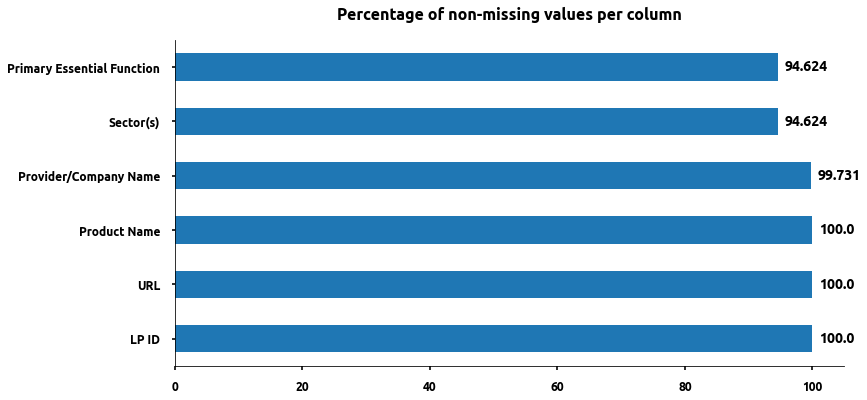

In [7]:
pct_df = pd.DataFrame(product_info_df.count() * 100 / len(product_info_df), 
                      columns=['Percent Non-Missing'])
pct_df['Percent Non-Missing'] = np.round(pct_df['Percent Non-Missing'], 3)

pct_df.plot(kind='barh', figsize=(12, 6), legend=False)
plt.title("Percentage of non-missing values per column", pad=20)

for i, v in enumerate(pct_df['Percent Non-Missing']):
    plt.text(v + 1, i - 0.07, str(v), color='k', fontsize=14)

In [8]:
product_info_df.fillna('UNK', inplace=True)
product_info_df['Number of Sectors'] = product_info_df['Sector(s)'].progress_apply(lambda x: 0 if x=='UNK' else len(x.split('; ')))
product_info_df['Sector_List'] = product_info_df['Sector(s)'].progress_apply(lambda x: x.split('; '))
product_info_df = product_info_df.drop('Sector_List', 1).join(product_info_df.Sector_List.str.join('|').str.get_dummies())

product_info_df['Essential Function Primary Category'] = product_info_df['Primary Essential Function'].progress_apply(lambda x: 'UNK' if x=='UNK' else x.split(' - ')[0])
product_info_df['Number of Sub Categories'] = product_info_df['Primary Essential Function'].progress_apply(lambda x: 0 if x=='UNK' else len(x.split(' - ')[1:]))
product_info_df['Essential Function Sub Category(1)'] = product_info_df['Primary Essential Function'].progress_apply(lambda x: 'None' if len(x.split(' - ')) < 2 else x.split(' - ')[1])
product_info_df['Essential Function Sub Category(2)'] = product_info_df['Primary Essential Function'].progress_apply(lambda x: 'None' if len(x.split(' - ')) < 3 else x.split(' - ')[2])

product_info_df.drop(['URL','Sector(s)','Primary Essential Function','UNK'], axis=1, inplace=True)
product_info_df.head(10)

100%|██████████| 372/372 [00:00<00:00, 213357.18it/s]


,LP ID,Product Name,Provider/Company Name,Number of Sectors,Corporate,Higher Ed,PreK-12,Essential Function Primary Category,Number of Sub Categories,Essential Function Sub Category(1),Essential Function Sub Category(2)
0,13117,SplashLearn,StudyPad Inc.,1,0,0,1,LC,1,Digital Learning Platforms,None
1,66933,ABCmouse.com,"Age of Learning, Inc",1,0,0,1,LC,1,Digital Learning Platforms,None
2,50479,ABCya!,"ABCya.com, LLC",1,0,0,1,LC,2,"Sites, Resources & Reference",Games & Simulations
3,92993,ALEKS,McGraw-Hill PreK-12,2,0,1,1,LC,1,Digital Learning Platforms,None
4,73104,Achieve3000,Achieve3000,1,0,0,1,LC,1,Digital Learning Platforms,None
5,37600,Actively Learn,Actively Learn,1,0,0,1,LC,1,Digital Learning Platforms,None
6,18663,AdaptedMind,GloWorld,1,0,0,1,LC,1,Digital Learning Platforms,None
7,65131,Amplify,"Amplify Education, Inc.",1,0,0,1,LC,1,Courseware & Textbooks,None
8,26491,Answers,Answers,2,0,1,1,LC,2,Study Tools,Q&A
9,56441,Audible,"Amazon.com, Inc.",3,1,1,1,LC,2,"Sites, Resources & Reference",Streaming Services


### Engagement data

#### - The engagement data are aggregated at school district level, and each file in the folder engagement_data represents data from one school district.
#### - The data contains page load events of over 10K education technology products, including websites, apps, web apps, software programs, extensions, ebooks, hardwares, and services used in educational institutions. 

| Name | Description |
| --- | --- |
| time | date in "YYYY-MM-DD"
| lp_id | The unique identifier of the product
| pct_access | Percentage of students in the district have at least one page-load event of a given product and on a given day
| engagement_index | Total page-load events per one thousand students of a given product and on a given day

In [9]:
path = '../input/learnplatform-covid19-impact-on-digital-learning/engagement_data' 
engagement_df = pd.DataFrame()

for file in tqdm(glob.glob(path + "/*.csv")):
    df = pd.read_csv(file, parse_dates=['time'])
    df["district_id"] = np.int(file.split("/")[4].split(".")[0])
    engagement_df = pd.concat([engagement_df, df])

print(f"Number of samples: {engagement_df.shape[0]}")
engagement_df.head(10)

100%|██████████| 233/233 [01:47<00:00,  2.17it/s]

Number of samples: 22324190


,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,92844.0,0.01,0.68,6345
1,2020-01-01,64838.0,0.01,0.68,6345
2,2020-01-01,94058.0,0.00,NaN,6345
3,2020-01-01,26488.0,0.03,26.21,6345
4,2020-01-01,32340.0,0.01,0.11,6345
5,2020-01-01,95731.0,0.20,40.96,6345
6,2020-01-01,92918.0,0.01,4.54,6345
7,2020-01-01,17307.0,0.00,NaN,6345
8,2020-01-01,96255.0,0.01,0.11,6345
9,2020-01-01,83862.0,0.01,0.11,6345


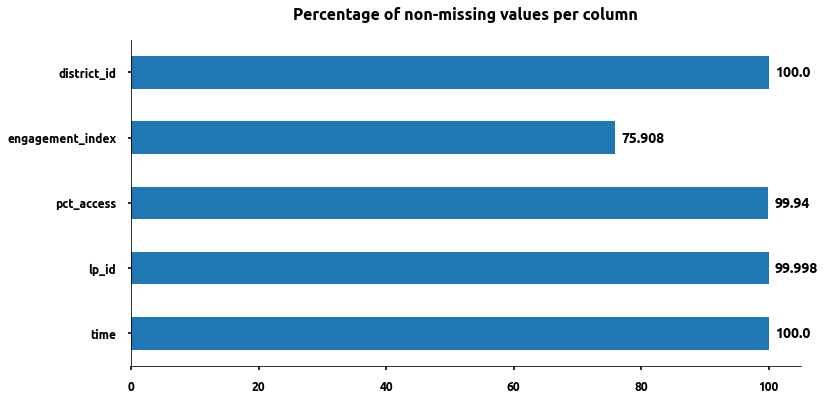

In [10]:
pct_df = pd.DataFrame(engagement_df.count() * 100 / len(engagement_df), 
                      columns=['Percent Non-Missing'])
pct_df['Percent Non-Missing'] = np.round(pct_df['Percent Non-Missing'], 3)

pct_df.plot(kind='barh', figsize=(12, 6), legend=False)
plt.title("Percentage of non-missing values per column", pad=20)

for i, v in enumerate(pct_df['Percent Non-Missing']):
    plt.text(v + 1, i - 0.07, str(v), color='k', fontsize=14)

In [11]:
engagement_df['lp_id'].fillna(-1, inplace=True)

agg_cols = ['district_id','lp_id']
agg_df = engagement_df[~engagement_df.duplicated(subset=['district_id','lp_id','engagement_index','pct_access'], keep='first')].copy()
agg_df = agg_df.groupby(agg_cols).agg({'engagement_index':'mean','pct_access':'mean'}).reset_index()
agg_df = agg_df.rename(columns={'engagement_index':'Mean_engagement_index', 'pct_access':'Mean_pct_access'})
agg_df.fillna(0, inplace=True)
agg_df['Mean_engagement_index'] = np.round(agg_df['Mean_engagement_index'], 2)
agg_df['Mean_pct_access'] = np.round(agg_df['Mean_pct_access'], 2)

engagement_df = pd.merge(engagement_df, agg_df, on=agg_cols, how='left', sort=False)
engagement_df['engagement_index'].fillna(engagement_df['Mean_engagement_index'], inplace=True)
engagement_df['pct_access'].fillna(engagement_df['Mean_pct_access'], inplace=True)
engagement_df.drop(['Mean_engagement_index','Mean_pct_access'], axis=1, inplace=True)

del agg_df
gc.collect()

engagement_df['quarter'] = engagement_df['time'].dt.quarter
engagement_df['month'] = engagement_df['time'].dt.month
engagement_df['day_week'] = pd.DatetimeIndex(engagement_df['time']).dayofweek
engagement_df['day_weekend'] = np.where(engagement_df['day_week'].isin([5,6]),1,0)
engagement_df.head()

,time,lp_id,pct_access,engagement_index,district_id,quarter,month,day_week,day_weekend
0,2020-01-01,92844.0,0.01,0.68,6345,1,1,2,0
1,2020-01-01,64838.0,0.01,0.68,6345,1,1,2,0
2,2020-01-01,94058.0,0.00,2.56,6345,1,1,2,0
3,2020-01-01,26488.0,0.03,26.21,6345,1,1,2,0
4,2020-01-01,32340.0,0.01,0.11,6345,1,1,2,0


## Picture of digital connectivity and engagement in 2020

### Time-series trend analysis for 2020

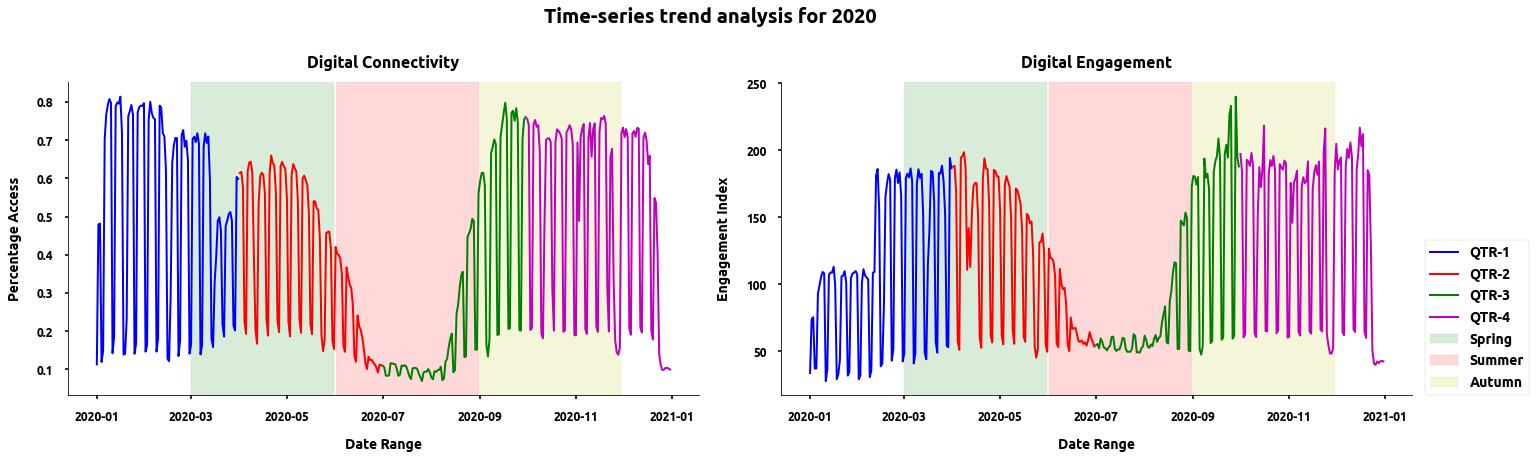

In [12]:
tmp = engagement_df\
        .groupby(['quarter','time'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(tmp[tmp['quarter']==1]['time'], tmp[tmp['quarter']==1]['pct_access'], color='b', label='QTR-1')
ax[0].plot(tmp[tmp['quarter']==2]['time'], tmp[tmp['quarter']==2]['pct_access'], color='r', label='QTR-2')
ax[0].plot(tmp[tmp['quarter']==3]['time'], tmp[tmp['quarter']==3]['pct_access'], color='g', label='QTR-3')
ax[0].plot(tmp[tmp['quarter']==4]['time'], tmp[tmp['quarter']==4]['pct_access'], color='m', label='QTR-4')
ax[0].axvspan('2020-03-01', '2020-05-31', color='g', alpha=0.15, label='Spring')
ax[0].axvspan('2020-06-01', '2020-08-31', color='r', alpha=0.15, label='Summer')
ax[0].axvspan('2020-09-01', '2020-11-30', color='y', alpha=0.15, label='Autumn')
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Date Range", labelpad=15)
ax[0].set_ylabel("Percentage Access", labelpad=15)

ax[1].plot(tmp[tmp['quarter']==1]['time'], tmp[tmp['quarter']==1]['engagement_index'], color='b', label='QTR-1')
ax[1].plot(tmp[tmp['quarter']==2]['time'], tmp[tmp['quarter']==2]['engagement_index'], color='r', label='QTR-2')
ax[1].plot(tmp[tmp['quarter']==3]['time'], tmp[tmp['quarter']==3]['engagement_index'], color='g', label='QTR-3')
ax[1].plot(tmp[tmp['quarter']==4]['time'], tmp[tmp['quarter']==4]['engagement_index'], color='m', label='QTR-4')
ax[1].axvspan('2020-03-01', '2020-05-31', color='g', alpha=0.15, label='Spring')
ax[1].axvspan('2020-06-01', '2020-08-31', color='r', alpha=0.15, label='Summer')
ax[1].axvspan('2020-09-01', '2020-11-30', color='y', alpha=0.15, label='Autumn')
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Date Range", labelpad=15)
ax[1].set_ylabel("Engagement Index", labelpad=15)

fig.tight_layout()
plt.suptitle("Time-series trend analysis for 2020",
             y=1.07, fontweight='bold')
plt.legend(loc=(1.02, 0));

**Observations**

* **Digital connectivity**:

   1. Decreased mildly during Quarter-1 (Jan to Mar)
   2. Decreased rapidly during Quarter-2 (Apr to Jun) and during **Spring** season (most states and local governments across the U.S. closed educational institutions)
   3. In **Summer** season (Jun to Aug), after low values in initial months, digital connectivity picked up again during later months
   4. In **Autumn** season (Sep to Nov), digital connectivity increased substantially and saturated to pre-Covid numbers (i.e. same as Quarter-1 values)
   
   
* **Digital engagement**:

   1. Increased during Quarter-1 (Jan to Mar)
   2. Decreased rapidly during Quarter-2 (Apr to Jun) and during **Spring** season (most states and local governments across the U.S. closed educational institutions)
   3. In **Summer** season (Jun to Aug), after low values in initial months, digital engagement picked up again during later months
   4. In **Autumn** season (Sep to Nov), digital engagement increased substantially and saturated to pre-Covid numbers (i.e. same as Quarter-1 values)

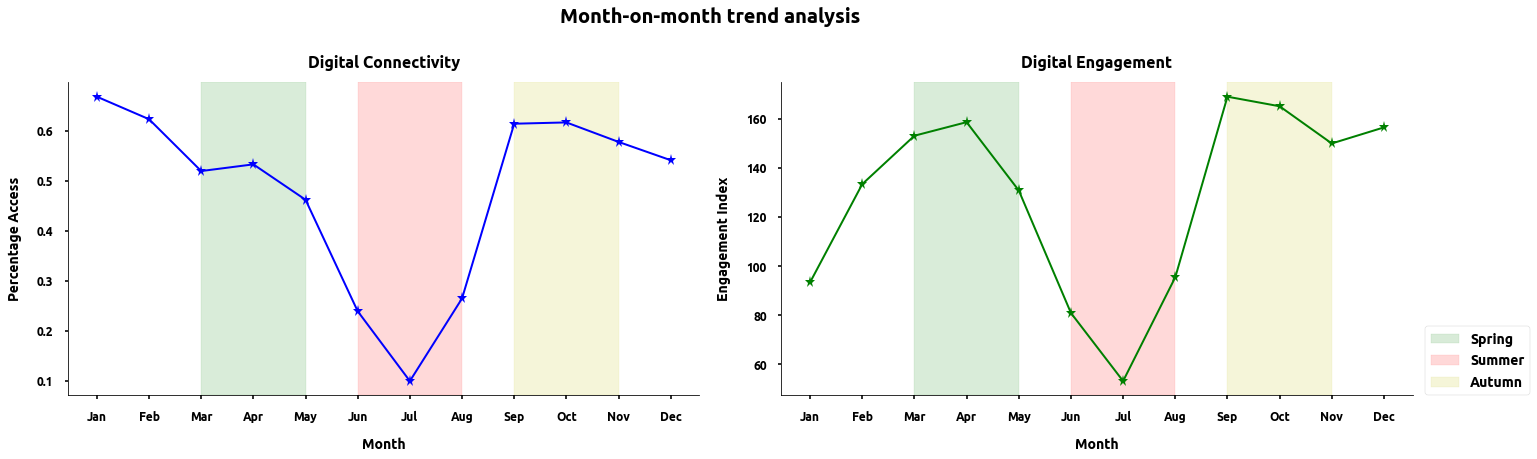

In [13]:
tmp = engagement_df\
        .groupby(['month'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp['engagement_index_mtd'] = tmp['engagement_index'] - tmp['engagement_index'].shift(1)
tmp['pct_access_mtd'] = tmp['pct_access'] - tmp['pct_access'].shift(1)
tmp.fillna(0, inplace=True)
tmp['month'] = tmp['month'].map({
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
})

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(tmp['month'], tmp['pct_access'], color='b', marker='*')
ax[0].axvspan('Mar', 'May', color='g', alpha=0.15, label='Spring')
ax[0].axvspan('Jun', 'Aug', color='r', alpha=0.15, label='Summer')
ax[0].axvspan('Sep', 'Nov', color='y', alpha=0.15, label='Autumn')
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Month", labelpad=15)
ax[0].set_ylabel("Percentage Access", labelpad=15)

ax[1].plot(tmp['month'], tmp['engagement_index'], color='g', marker='*')
ax[1].axvspan('Mar', 'May', color='g', alpha=0.15, label='Spring')
ax[1].axvspan('Jun', 'Aug', color='r', alpha=0.15, label='Summer')
ax[1].axvspan('Sep', 'Nov', color='y', alpha=0.15, label='Autumn')
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Month", labelpad=15)
ax[1].set_ylabel("Engagement Index", labelpad=15)

fig.tight_layout()
plt.suptitle("Month-on-month trend analysis", 
             y=1.07, fontweight='bold')
plt.legend(loc=(1.02, 0));

**Observations**

* **April** and **September** seem to be the **uplifting months**, where digital connectivity and engagement both increased compared to prior months
* **July** was the **worst-hit month**, where digital connectivity and engagement both took a dive to lowest figures

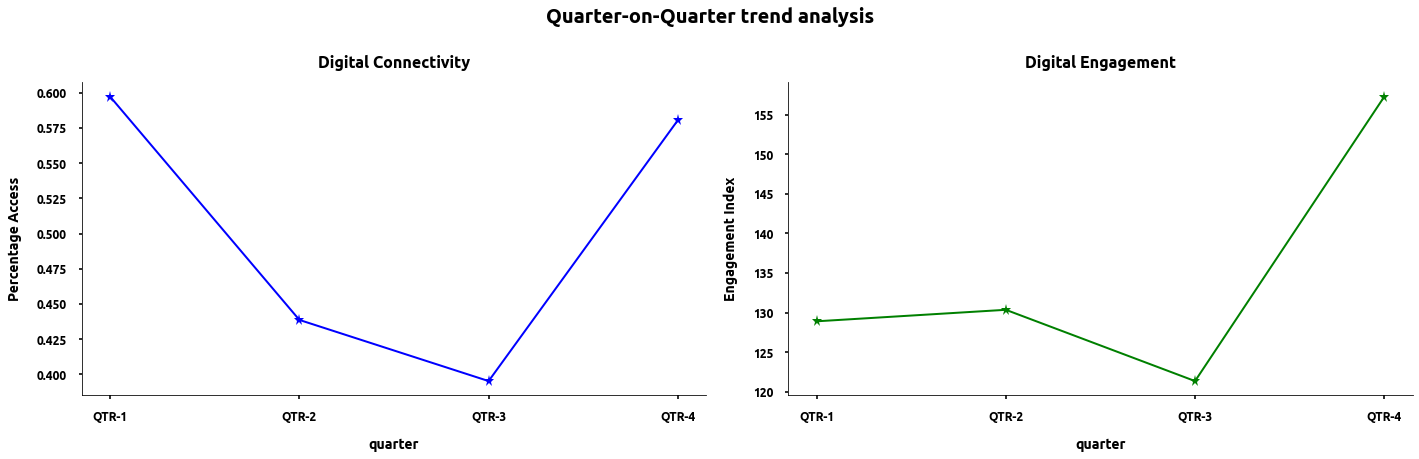

In [14]:
tmp = engagement_df\
        .groupby(['quarter'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp['engagement_index_mtd'] = tmp['engagement_index'] - tmp['engagement_index'].shift(1)
tmp['pct_access_mtd'] = tmp['pct_access'] - tmp['pct_access'].shift(1)
tmp.fillna(0, inplace=True)
tmp['quarter'] = tmp['quarter'].map({1:'QTR-1',2:'QTR-2',3:'QTR-3',4:'QTR-4'})

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(tmp['quarter'], tmp['pct_access'], color='b', marker='*')
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("quarter", labelpad=15)
ax[0].set_ylabel("Percentage Access", labelpad=15)

ax[1].plot(tmp['quarter'], tmp['engagement_index'], color='g', marker='*')
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("quarter", labelpad=15)
ax[1].set_ylabel("Engagement Index", labelpad=15)

fig.tight_layout()
plt.suptitle("Quarter-on-Quarter trend analysis", 
             y=1.07, fontweight='bold');

**Observations**

* Both digital connectivity and engagement took a dive during Quarters-1, 2 and 3
* **Quarter-3** was the **worst-hit**, where both digital connectivity and engagement reached lowest figures
* **Quarter-4** was the **uplifting quarter**, where digital connectivity and engagement increased substantially compared to prior quarters

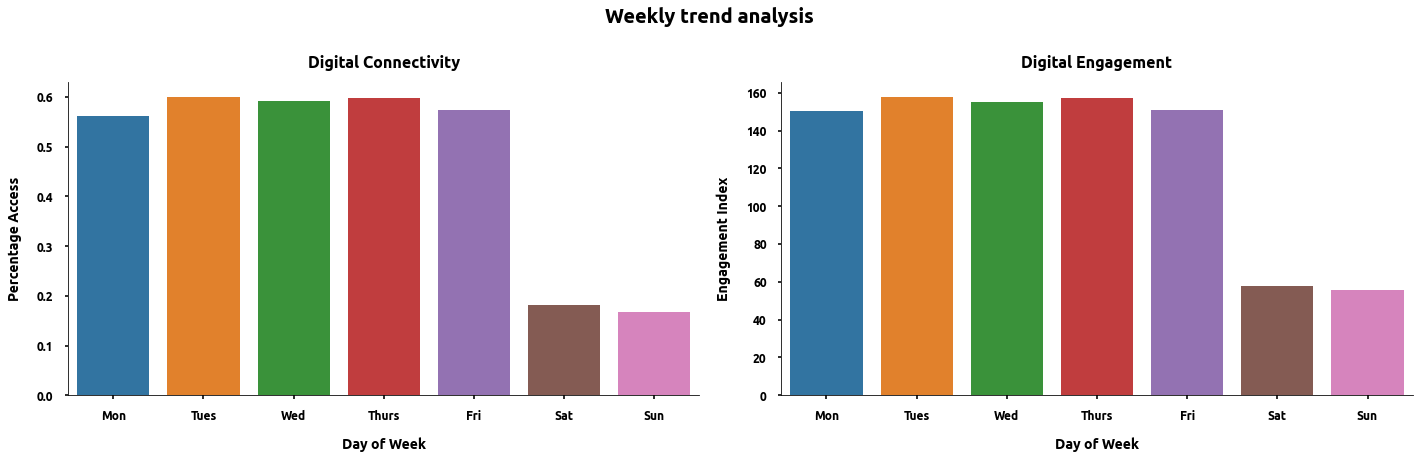

In [15]:
tmp = engagement_df\
        .groupby(['day_week'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp['day_week'] = tmp['day_week'].map({0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'})

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x='day_week', y='pct_access', data=tmp, ax=ax[0])
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Day of Week", labelpad=15)
ax[0].set_ylabel("Percentage Access", labelpad=15)

sns.barplot(x='day_week', y='engagement_index', data=tmp, ax=ax[1])
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Day of Week", labelpad=15)
ax[1].set_ylabel("Engagement Index", labelpad=15)

fig.tight_layout()
plt.suptitle("Weekly trend analysis", 
             y=1.07, fontweight='bold');

**Observations**
* Both digital connectivity and engagement are **high during weekdays** (Mon to Fri)
* Digital connectivity and engagement **drops to more than half during weekends** (Sat & Sun)

### Trend analysis across different digital products

In [16]:
df = pd.merge(
    engagement_df,
    product_info_df,
    how='left',
    left_on='lp_id', 
    right_on='LP ID'
)

df['Essential Function Primary Category'].fillna('UNK', inplace=True)
df.drop(['lp_id'], axis=1, inplace=True)
df.head()

,time,pct_access,engagement_index,district_id,quarter,month,day_week,day_weekend,LP ID,Product Name,Provider/Company Name,Number of Sectors,Corporate,Higher Ed,PreK-12,Essential Function Primary Category,Number of Sub Categories,Essential Function Sub Category(1),Essential Function Sub Category(2)
0,2020-01-01,0.01,0.68,6345,1,1,2,0,92844.0,Typing.com,Teaching.com,3.0,1.0,1.0,1.0,LC,1.0,Digital Learning Platforms,None
1,2020-01-01,0.01,0.68,6345,1,1,2,0,64838.0,Starfall,Starfall Education,1.0,0.0,0.0,1.0,LC,2.0,"Sites, Resources & Reference",Games & Simulations
2,2020-01-01,0.00,2.56,6345,1,1,2,0,94058.0,Course Hero,Course Hero,2.0,0.0,1.0,1.0,LC,1.0,Study Tools,None
3,2020-01-01,0.03,26.21,6345,1,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UNK,NaN,NaN,NaN
4,2020-01-01,0.01,0.11,6345,1,1,2,0,32340.0,Education Genius,Genius Media Group,0.0,0.0,0.0,0.0,UNK,0.0,None,None


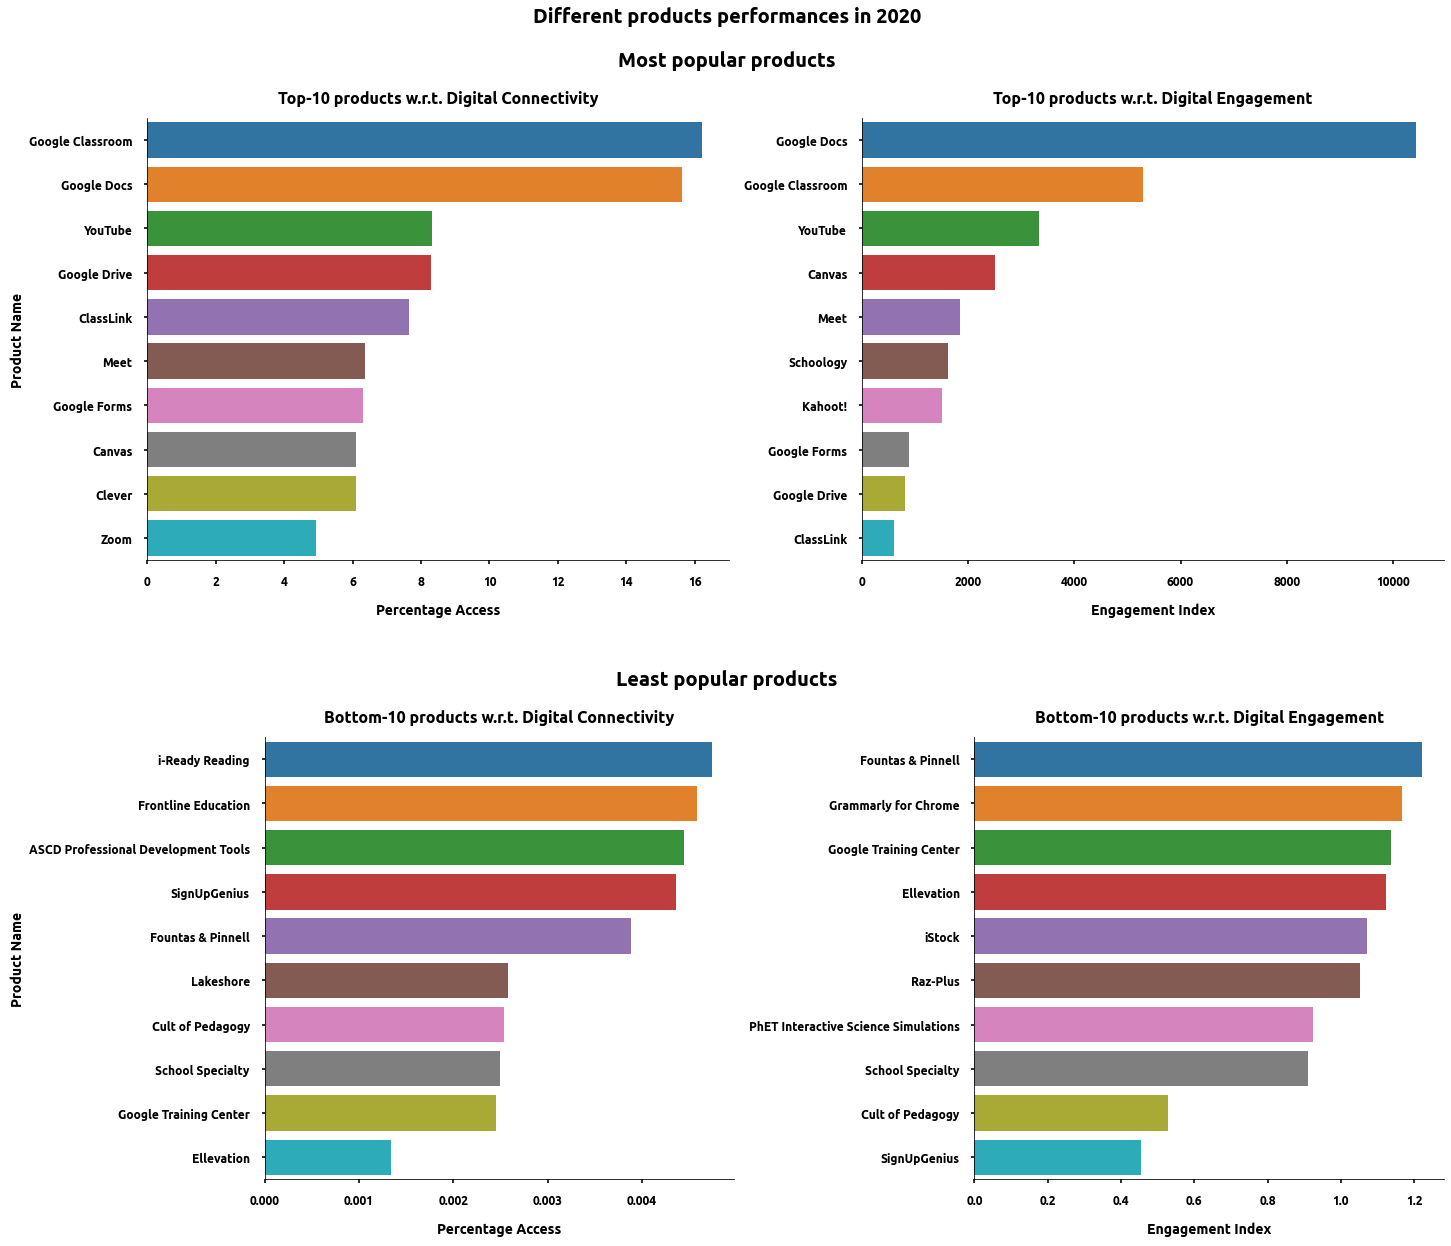

In [17]:
tmp = df.groupby(['Provider/Company Name','Product Name'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()


fig = plt.figure(figsize=(20, 16), constrained_layout=True)
fig.suptitle('Different products performances in 2020',
             y=1.07, fontweight='bold')

subfigs = fig.subfigures(nrows=2, ncols=1, wspace=0.15, hspace=0.15)
for row, subfig in enumerate(subfigs):
    if row==0:
        subfig.suptitle("Most popular products", y=1.07, fontweight='bold')

        ax = subfig.subplots(nrows=1, ncols=2)
        sns.barplot(x='pct_access', y='Product Name', ax=ax[0], 
                    data=tmp.sort_values(by='pct_access', ascending=False).head(10))
        ax[0].set_title("Top-10 products w.r.t. Digital Connectivity", pad=15)
        ax[0].set_xlabel("Percentage Access", labelpad=15)

        sns.barplot(x='engagement_index', y='Product Name', ax=ax[1], 
                    data=tmp.sort_values(by='engagement_index', ascending=False).head(10))
        ax[1].set_title("Top-10 products w.r.t. Digital Engagement", pad=15)
        ax[1].set_xlabel("Engagement Index", labelpad=15)
        ax[1].set(ylabel=None)
    
    else:
        subfig.suptitle("Least popular products", y=1.07, fontweight='bold')

        ax = subfig.subplots(nrows=1, ncols=2)
        sns.barplot(x='pct_access', y='Product Name', ax=ax[0], 
                    data=tmp.sort_values(by='pct_access', ascending=False).tail(10))
        ax[0].set_title("Bottom-10 products w.r.t. Digital Connectivity", pad=15)
        ax[0].set_xlabel("Percentage Access", labelpad=15)

        sns.barplot(x='engagement_index', y='Product Name', ax=ax[1], 
                    data=tmp.sort_values(by='engagement_index', ascending=False).tail(10))
        ax[1].set_title("Bottom-10 products w.r.t. Digital Engagement", pad=15)
        ax[1].set_xlabel("Engagement Index", labelpad=15)
        ax[1].set(ylabel=None)

**Observations**

* **Google Classroom** and **Google Docs** were the **most popular products** w.r.t. Digital connectivity and engagement
* **Ellevation** was the **least popular product** w.r.t. Digital Connectivity
* **SignUpGenius** was the **least popular product** w.r.t. Digital Engagement

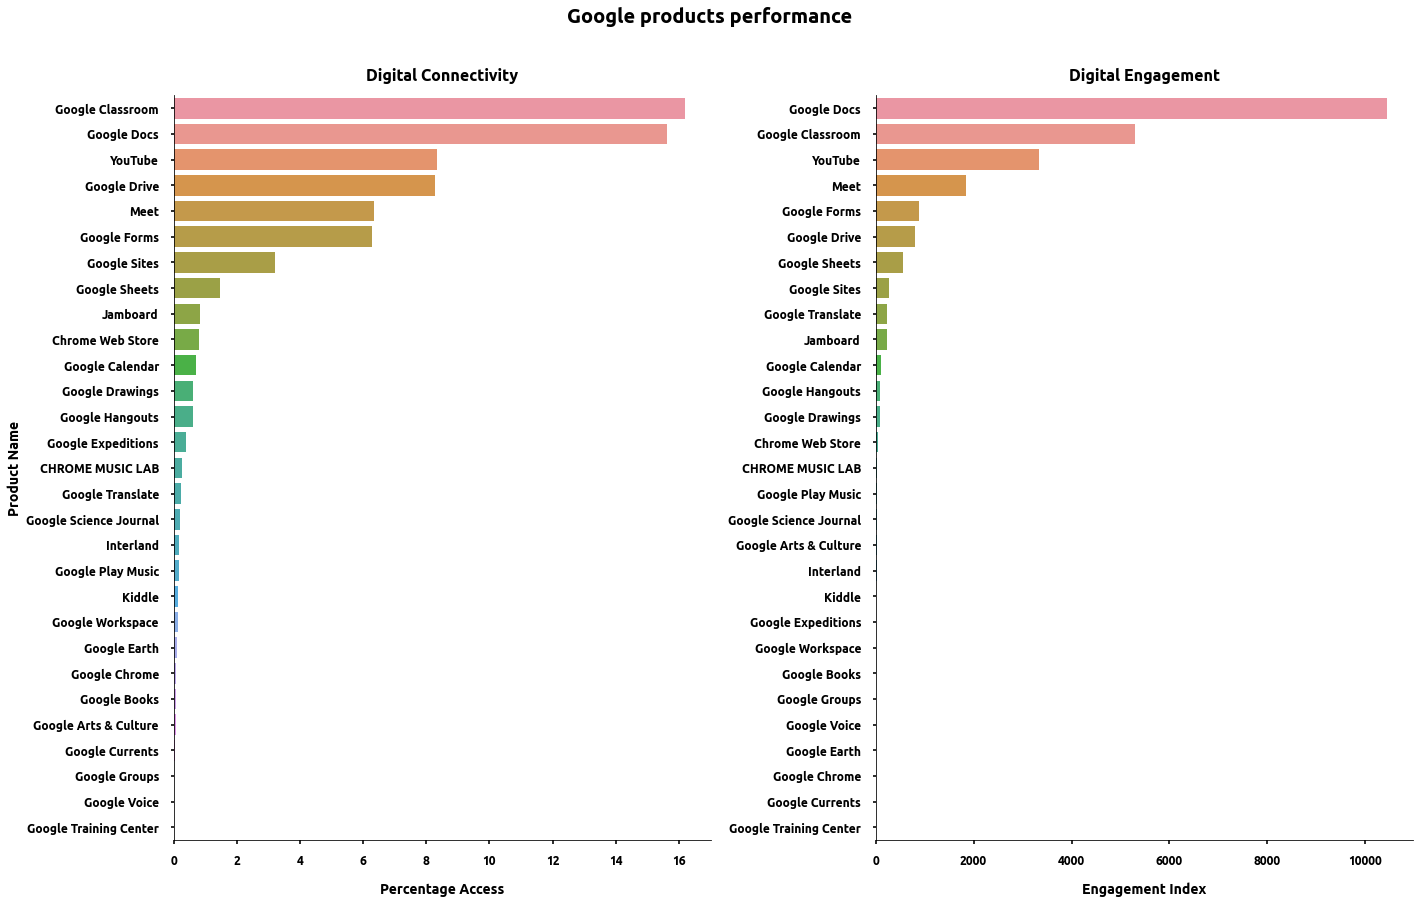

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

sns.barplot(x='pct_access', y='Product Name', ax=ax[0], 
            data=tmp[tmp['Provider/Company Name']=='Google LLC'].sort_values(by='pct_access', ascending=False))
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Percentage Access", labelpad=15)

sns.barplot(x='engagement_index', y='Product Name', ax=ax[1], 
            data=tmp[tmp['Provider/Company Name']=='Google LLC'].sort_values(by='engagement_index', ascending=False))
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Engagement Index", labelpad=15)
ax[1].set(ylabel=None)

fig.tight_layout()
plt.suptitle("Google products performance", 
             y=1.05, fontweight='bold');

**Observations**
* **Google Docs** and **Google Classroom** were the **most popular Google products** w.r.t. Digital connectivity and engagement
* **Google Training Center** was the **least popular Google product**

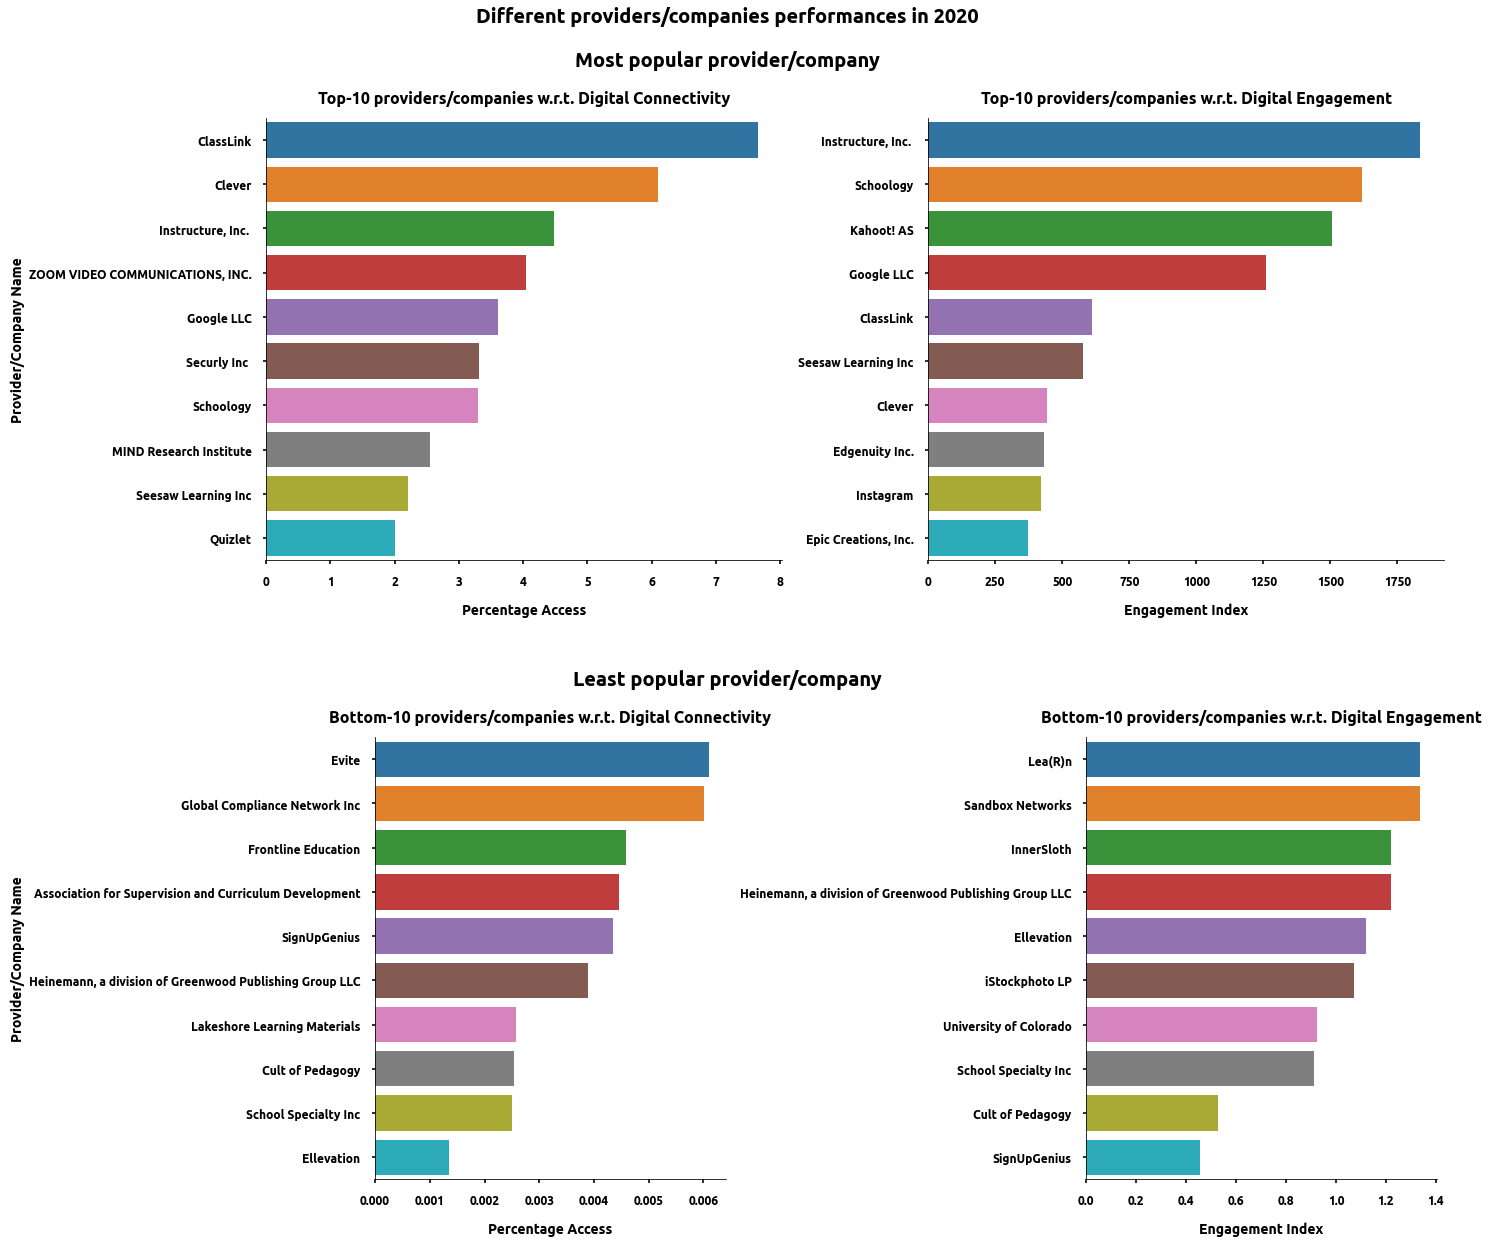

In [19]:
tmp = df.groupby(['Provider/Company Name'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()


fig = plt.figure(figsize=(20, 16), constrained_layout=True)
fig.suptitle('Different providers/companies performances in 2020',
             y=1.07, fontweight='bold')

subfigs = fig.subfigures(nrows=2, ncols=1, wspace=0.15, hspace=0.15)
for row, subfig in enumerate(subfigs):
    if row==0:
        subfig.suptitle("Most popular provider/company", y=1.07, fontweight='bold')

        ax = subfig.subplots(nrows=1, ncols=2)
        sns.barplot(x='pct_access', y='Provider/Company Name', ax=ax[0], 
                    data=tmp.sort_values(by='pct_access', ascending=False).head(10))
        ax[0].set_title("Top-10 providers/companies w.r.t. Digital Connectivity", pad=15)
        ax[0].set_xlabel("Percentage Access", labelpad=15)

        sns.barplot(x='engagement_index', y='Provider/Company Name', ax=ax[1], 
                    data=tmp.sort_values(by='engagement_index', ascending=False).head(10))
        ax[1].set_title("Top-10 providers/companies w.r.t. Digital Engagement", pad=15)
        ax[1].set_xlabel("Engagement Index", labelpad=15)
        ax[1].set(ylabel=None)
    
    else:
        subfig.suptitle("Least popular provider/company", y=1.07, fontweight='bold')

        ax = subfig.subplots(nrows=1, ncols=2)
        sns.barplot(x='pct_access', y='Provider/Company Name', ax=ax[0], 
                    data=tmp.sort_values(by='pct_access', ascending=False).tail(10))
        ax[0].set_title("Bottom-10 providers/companies w.r.t. Digital Connectivity", pad=15)
        ax[0].set_xlabel("Percentage Access", labelpad=15)

        sns.barplot(x='engagement_index', y='Provider/Company Name', ax=ax[1], 
                    data=tmp.sort_values(by='engagement_index', ascending=False).tail(10))
        ax[1].set_title("Bottom-10 providers/companies w.r.t. Digital Engagement", pad=15)
        ax[1].set_xlabel("Engagement Index", labelpad=15)
        ax[1].set(ylabel=None)

**Observations**

* **ClassLink** seems to be the **most popular provider** w.r.t. Digital Connectivity
* **Infrastructure, Inc.** seems to be the **most popular provider** w.r.t. Digital Engagement
* **Ellevation** was the **least popular provider** w.r.t. Digital connectivity
* **SignUpGenius** was the **least popular provider** w.r.t. Digital Engagement

### Trend analysis across different digital sectors

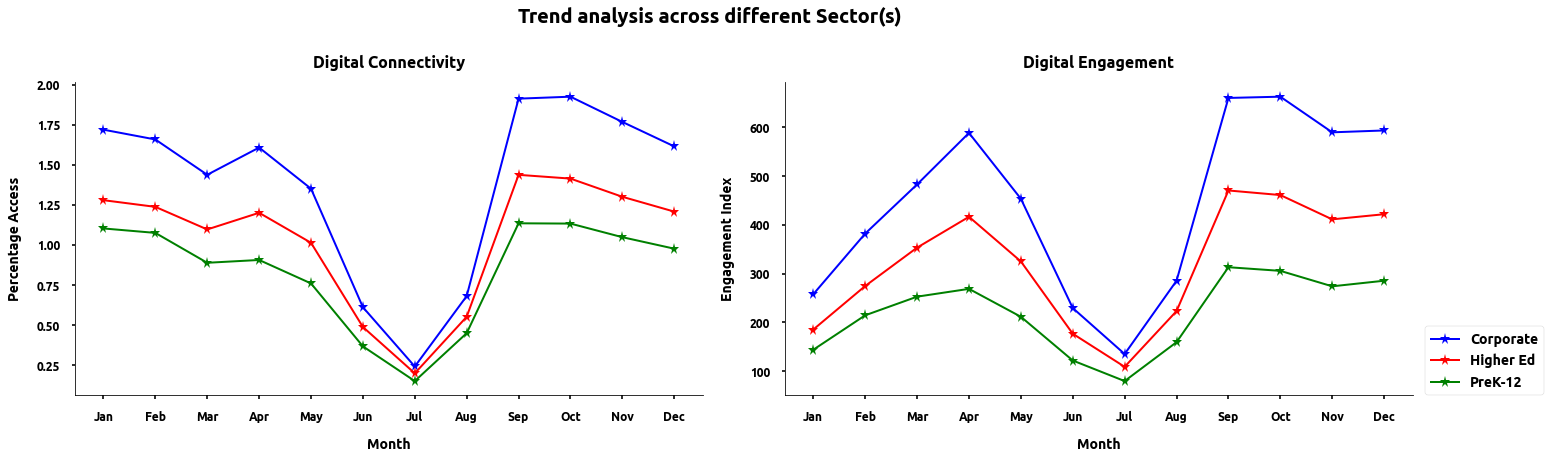

In [20]:
tmp1 = df[df['Corporate']==1].groupby(['month']).agg({'engagement_index':'mean', 'pct_access':'mean'}).reset_index().copy()
tmp2 = df[df['Higher Ed']==1].groupby(['month']).agg({'engagement_index':'mean', 'pct_access':'mean'}).reset_index().copy()
tmp3 = df[df['PreK-12']==1].groupby(['month']).agg({'engagement_index':'mean', 'pct_access':'mean'}).reset_index().copy()

month_dict = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

tmp1['month'] = tmp1['month'].map(month_dict)
tmp2['month'] = tmp2['month'].map(month_dict)
tmp3['month'] = tmp3['month'].map(month_dict)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(tmp1['month'], tmp1['pct_access'], color='b', marker='*', label='Corporate')
ax[0].plot(tmp2['month'], tmp2['pct_access'], color='r', marker='*', label='Higher Ed')
ax[0].plot(tmp3['month'], tmp3['pct_access'], color='g', marker='*', label='PreK-12')
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Month", labelpad=15)
ax[0].set_ylabel("Percentage Access", labelpad=15)

ax[1].plot(tmp1['month'], tmp1['engagement_index'], color='b', marker='*', label='Corporate')
ax[1].plot(tmp2['month'], tmp2['engagement_index'], color='r', marker='*', label='Higher Ed')
ax[1].plot(tmp3['month'], tmp3['engagement_index'], color='g', marker='*', label='PreK-12')
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Month", labelpad=15)
ax[1].set_ylabel("Engagement Index", labelpad=15)

fig.tight_layout()
plt.suptitle("Trend analysis across different Sector(s)", 
             y=1.07, fontweight='bold')
plt.legend(loc=(1.02, 0));

**Observations**

* There's similar trend w.r.t. Digital connectivity and engagement across all sectors (Corporate, Higher Ed and PreK-12)
* **Corporate** sector **performed best** w.r.t. Digital connectivity and engagement
* **PreK-12** sector (public elementary and secondary schools) **performed worst** w.r.t. Digital connectivity and engagement

### Trend analysis across different essential function categories

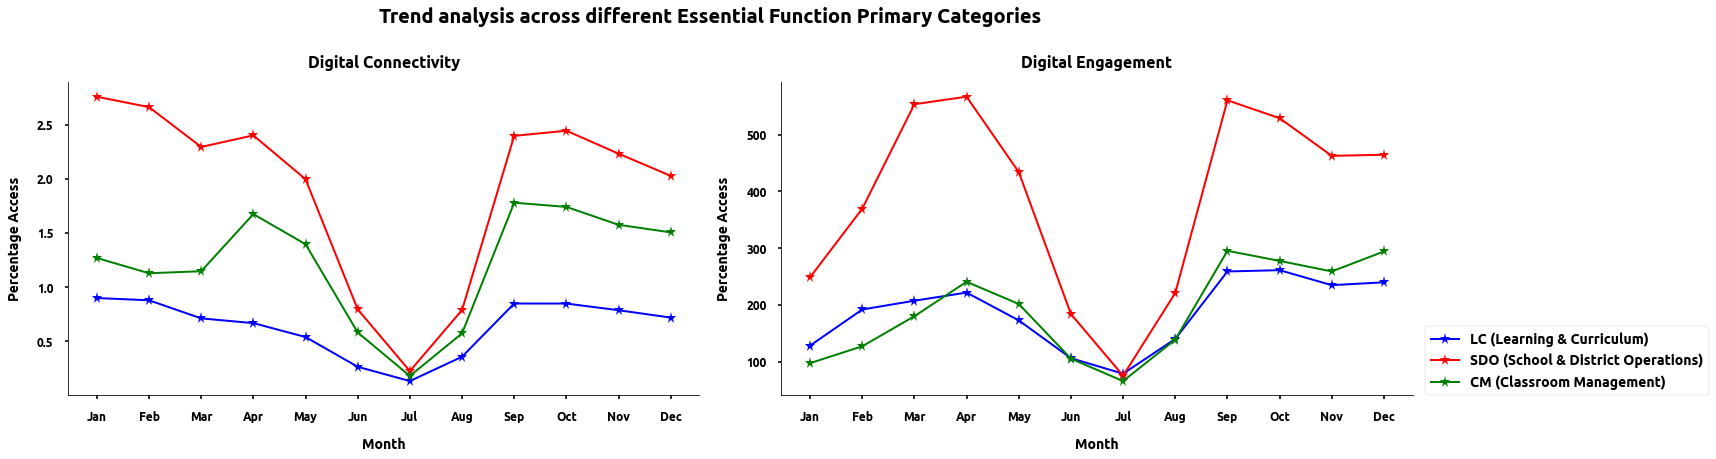

In [21]:
tmp1 = df[df['Essential Function Primary Category'].str.contains('LC')]\
        .groupby(['month'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp2 = df[df['Essential Function Primary Category'].str.contains('SDO')]\
        .groupby(['month'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp3 = df[df['Essential Function Primary Category'].str.contains('CM')]\
        .groupby(['month'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

month_dict = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

tmp1['month'] = tmp1['month'].map(month_dict)
tmp2['month'] = tmp2['month'].map(month_dict)
tmp3['month'] = tmp3['month'].map(month_dict)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(tmp1['month'], tmp1['pct_access'], color='b', marker='*', label='LC (Learning & Curriculum)')
ax[0].plot(tmp2['month'], tmp2['pct_access'], color='r', marker='*', label='SDO (School & District Operations)')
ax[0].plot(tmp3['month'], tmp3['pct_access'], color='g', marker='*', label='CM (Classroom Management)')
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Month", labelpad=15)
ax[0].set_ylabel("Percentage Access", labelpad=15)

ax[1].plot(tmp1['month'], tmp1['engagement_index'], color='b', marker='*', label='LC (Learning & Curriculum)')
ax[1].plot(tmp2['month'], tmp2['engagement_index'], color='r', marker='*', label='SDO (School & District Operations)')
ax[1].plot(tmp3['month'], tmp3['engagement_index'], color='g', marker='*', label='CM (Classroom Management)')
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Month", labelpad=15)
ax[1].set_ylabel("Percentage Access", labelpad=15)

fig.tight_layout()
plt.suptitle("Trend analysis across different Essential Function Primary Categories", 
             y=1.07, fontweight='bold')
plt.legend(loc=(1.02, 0));

**Observations**

* There's similar trend w.r.t. Digital connectivity and engagement across all categories (LC, SDO and CM)
* **CM (Classroom Management)** performed best w.r.t. Digital connectivity and engagement
* **LC (Learning & Curriculum)** performed worst w.r.t. Digital connectivity and engagement

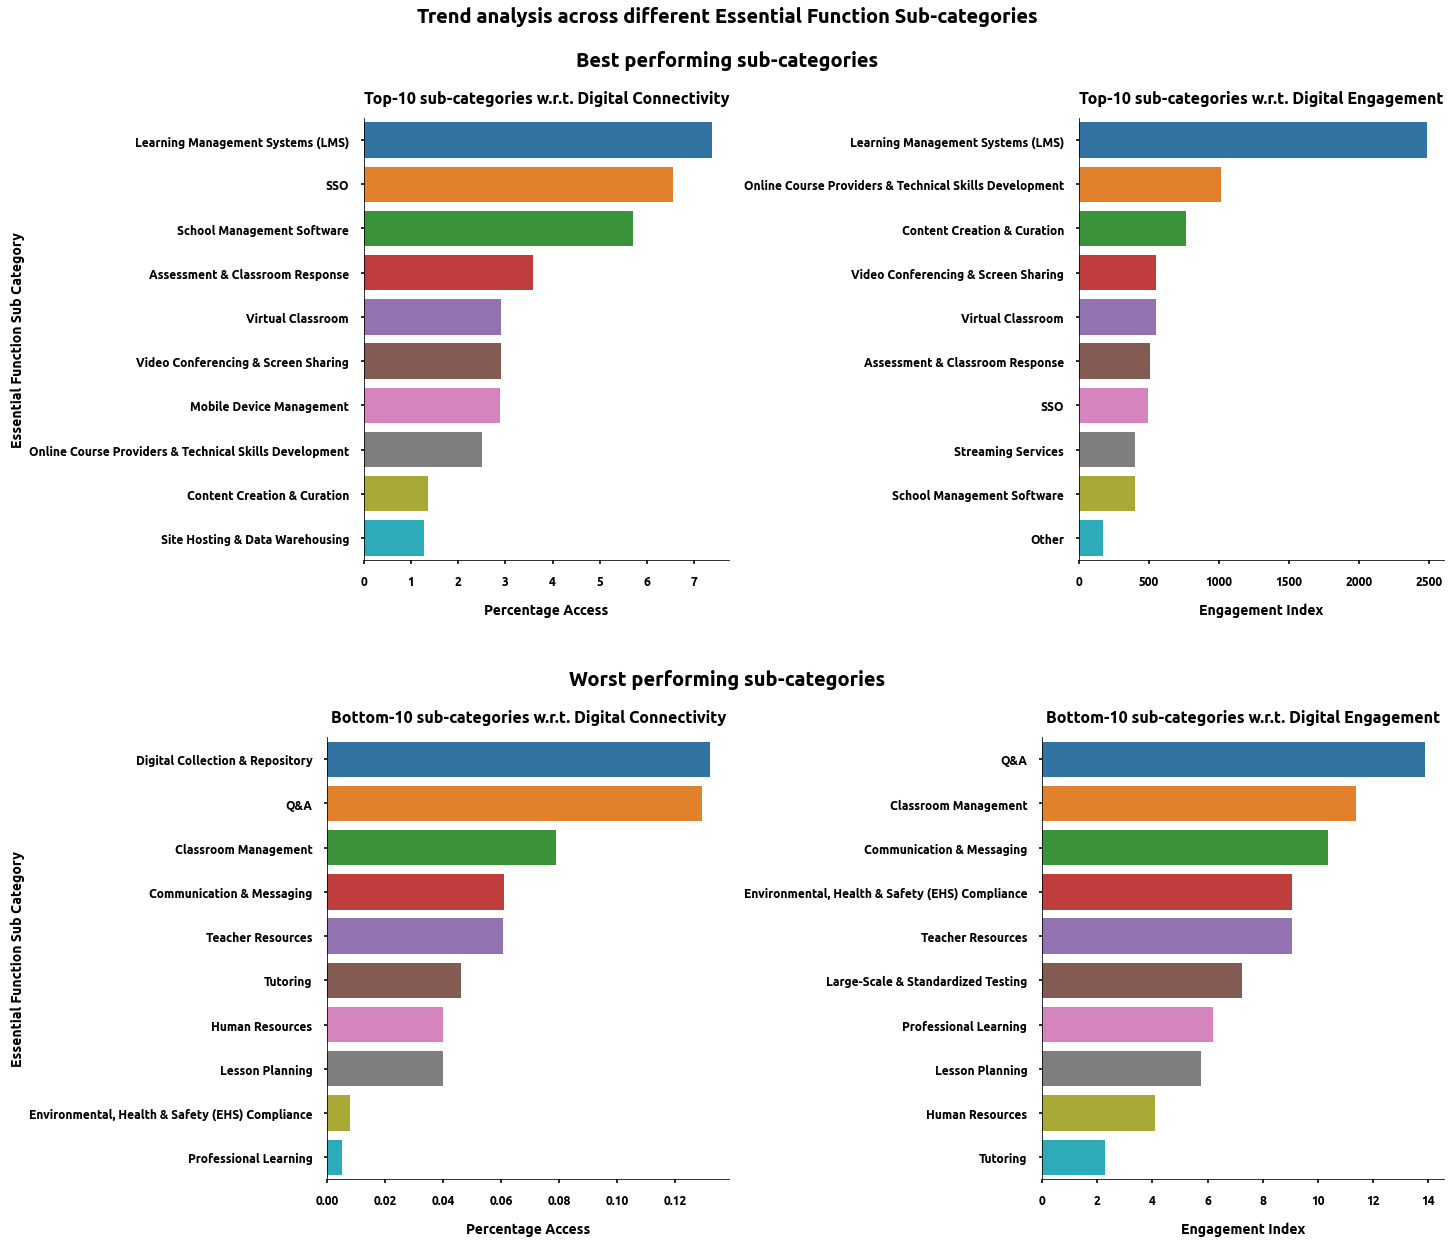

In [22]:
tmp1 = df[~((df['Essential Function Sub Category(1)'].isnull())|
            (df['Essential Function Sub Category(1)']=='None'))]\
        .groupby(['Essential Function Sub Category(1)'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .rename(columns={'Essential Function Sub Category(1)':'Essential Function Sub Category'})\
        .copy()

tmp2 = df[~((df['Essential Function Sub Category(2)'].isnull())|
            (df['Essential Function Sub Category(2)']=='None'))]\
        .groupby(['Essential Function Sub Category(2)'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .rename(columns={'Essential Function Sub Category(2)':'Essential Function Sub Category'})\
        .copy()

tmp = pd.concat([tmp1, tmp2], ignore_index=True)
del tmp1, tmp2
gc.collect()

fig = plt.figure(figsize=(20, 16), constrained_layout=True)
fig.suptitle('Trend analysis across different Essential Function Sub-categories',
             y=1.07, fontweight='bold')

subfigs = fig.subfigures(nrows=2, ncols=1, wspace=0.15, hspace=0.15)
for row, subfig in enumerate(subfigs):
    if row==0:
        subfig.suptitle("Best performing sub-categories", y=1.07, fontweight='bold')

        ax = subfig.subplots(nrows=1, ncols=2)
        sns.barplot(x='pct_access', y='Essential Function Sub Category', ax=ax[0], 
                    data=tmp.sort_values(by='pct_access', ascending=False).head(10))
        ax[0].set_title("Top-10 sub-categories w.r.t. Digital Connectivity", pad=15)
        ax[0].set_xlabel("Percentage Access", labelpad=15)

        sns.barplot(x='engagement_index', y='Essential Function Sub Category', ax=ax[1], 
                    data=tmp.sort_values(by='engagement_index', ascending=False).head(10))
        ax[1].set_title("Top-10 sub-categories w.r.t. Digital Engagement", pad=15)
        ax[1].set_xlabel("Engagement Index", labelpad=15)
        ax[1].set(ylabel=None)
    
    else:
        subfig.suptitle("Worst performing sub-categories", y=1.07, fontweight='bold')

        ax = subfig.subplots(nrows=1, ncols=2)
        sns.barplot(x='pct_access', y='Essential Function Sub Category', ax=ax[0], 
                    data=tmp.sort_values(by='pct_access', ascending=False).tail(10))
        ax[0].set_title("Bottom-10 sub-categories w.r.t. Digital Connectivity", pad=15)
        ax[0].set_xlabel("Percentage Access", labelpad=15)

        sns.barplot(x='engagement_index', y='Essential Function Sub Category', ax=ax[1], 
                    data=tmp.sort_values(by='engagement_index', ascending=False).tail(10))
        ax[1].set_title("Bottom-10 sub-categories w.r.t. Digital Engagement", pad=15)
        ax[1].set_xlabel("Engagement Index", labelpad=15)
        ax[1].set(ylabel=None)

**Observations**

* **Learning Management System (LMS)** sub-category had the **highest digital connectivity and engagement**
* **Professional Learning** sub-category had the **lowest digital connectivity**
* **Tutoring** sub-category had the **lowest digital engagement**

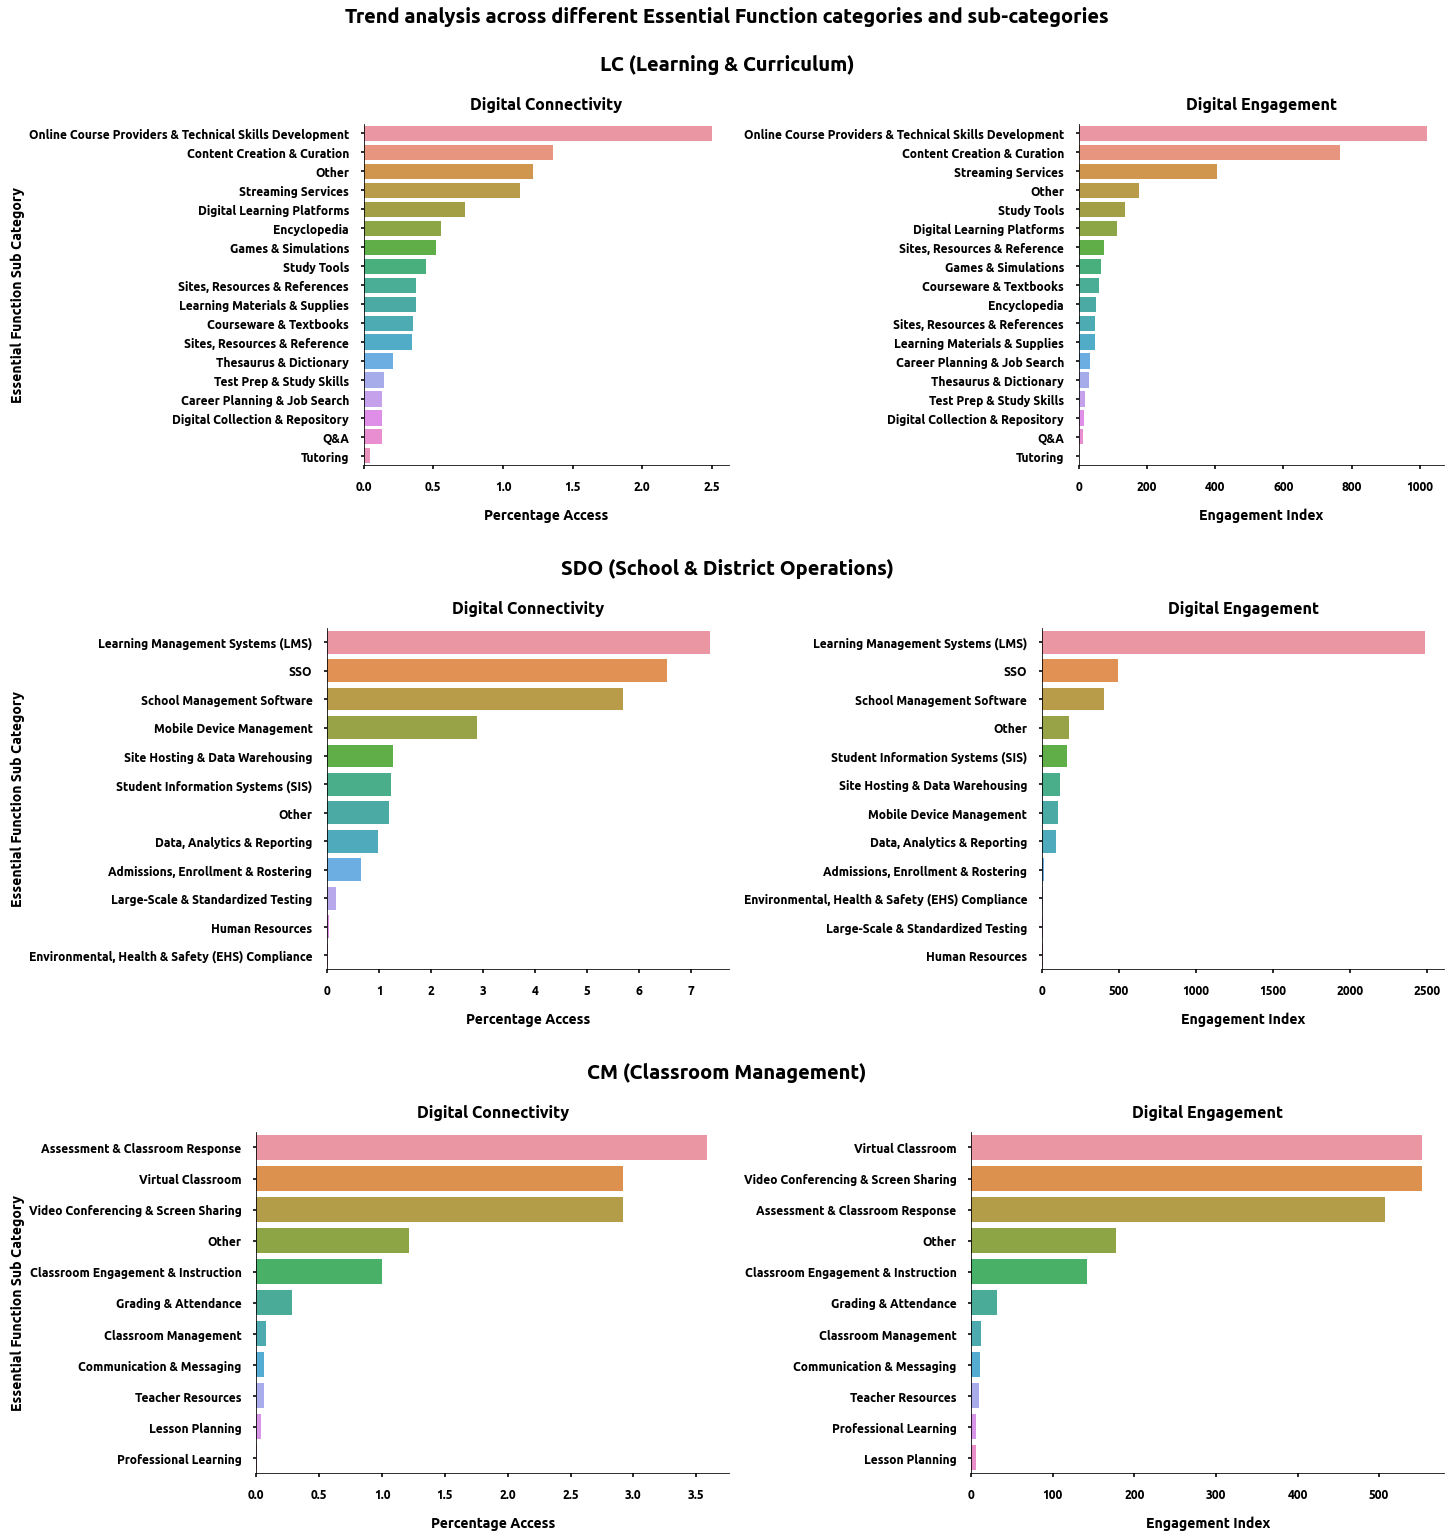

In [23]:
tmp1 = df[df['Essential Function Primary Category'].str.contains('LC')]\
        .groupby(['Essential Function Sub Category(1)'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .rename(columns={'Essential Function Sub Category(1)':'Essential Function Sub Category'})\
        .copy()

tmp1 = tmp1[~((tmp1['Essential Function Sub Category'].isnull())|
              (tmp1['Essential Function Sub Category']=='None'))].copy()
tmp1['Essential Function Primary Category'] = 'LC'


tmp2 = df[df['Essential Function Primary Category'].str.contains('LC')]\
        .groupby(['Essential Function Sub Category(2)'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .rename(columns={'Essential Function Sub Category(2)':'Essential Function Sub Category'})\
        .copy()

tmp2 = tmp2[~((tmp2['Essential Function Sub Category'].isnull())|
              (tmp2['Essential Function Sub Category']=='None'))].copy()
tmp2['Essential Function Primary Category'] = 'LC'


tmp3 = df[df['Essential Function Primary Category'].str.contains('SDO')]\
        .groupby(['Essential Function Sub Category(1)'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .rename(columns={'Essential Function Sub Category(1)':'Essential Function Sub Category'})\
        .copy()
tmp3 = tmp3[~((tmp3['Essential Function Sub Category'].isnull())|
              (tmp3['Essential Function Sub Category']=='None'))].copy()
tmp3['Essential Function Primary Category'] = 'SDO'


tmp4 = df[df['Essential Function Primary Category'].str.contains('SDO')]\
        .groupby(['Essential Function Sub Category(2)'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .rename(columns={'Essential Function Sub Category(2)':'Essential Function Sub Category'})\
        .copy()
tmp4 = tmp4[~((tmp4['Essential Function Sub Category'].isnull())|
              (tmp4['Essential Function Sub Category']=='None'))].copy()
tmp4['Essential Function Primary Category'] = 'SDO'


tmp5 = df[df['Essential Function Primary Category'].str.contains('CM')]\
        .groupby(['Essential Function Sub Category(1)'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .rename(columns={'Essential Function Sub Category(1)':'Essential Function Sub Category'})\
        .copy()
tmp5 = tmp5[~((tmp5['Essential Function Sub Category'].isnull())|
              (tmp5['Essential Function Sub Category']=='None'))].copy()
tmp5['Essential Function Primary Category'] = 'CM'


tmp6 = df[df['Essential Function Primary Category'].str.contains('CM')]\
        .groupby(['Essential Function Sub Category(2)'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .rename(columns={'Essential Function Sub Category(2)':'Essential Function Sub Category'})\
        .copy()
tmp6 = tmp6[~((tmp6['Essential Function Sub Category'].isnull())|
              (tmp6['Essential Function Sub Category']=='None'))].copy()
tmp6['Essential Function Primary Category'] = 'CM'


tmp = pd.concat([tmp1, tmp2, tmp3, tmp4, tmp5, tmp6], ignore_index=True)
del tmp1, tmp2, tmp3, tmp4, tmp5, tmp6
gc.collect()


fig = plt.figure(figsize=(20, 20), constrained_layout=True)
fig.suptitle('Trend analysis across different Essential Function categories and sub-categories',
             y=1.06, fontweight='bold')

subfigs = fig.subfigures(nrows=3, ncols=1, wspace=0.15, hspace=0.15)
for row, subfig in enumerate(subfigs):
    if row==0:
        title='LC (Learning & Curriculum)'
        cat_filter='LC'
    elif row==1:
        title='SDO (School & District Operations)'
        cat_filter='SDO'
    elif row==2:
        title='CM (Classroom Management)'
        cat_filter='CM'
    
    subfig.suptitle(title, y=1.09, fontweight='bold')

    ax = subfig.subplots(nrows=1, ncols=2)
    sns.barplot(x='pct_access', y='Essential Function Sub Category', ax=ax[0], 
                data=tmp[tmp['Essential Function Primary Category']==cat_filter]\
                        .sort_values(by='pct_access', ascending=False))
    ax[0].set_title("Digital Connectivity", pad=15)
    ax[0].set_xlabel("Percentage Access", labelpad=15)

    sns.barplot(x='engagement_index', y='Essential Function Sub Category', ax=ax[1], 
                data=tmp[tmp['Essential Function Primary Category']==cat_filter]\
                        .sort_values(by='engagement_index', ascending=False))
    ax[1].set_title("Digital Engagement", pad=15)
    ax[1].set_xlabel("Engagement Index", labelpad=15)
    ax[1].set(ylabel=None)

**Observations**

* Within **Learning & Curriculum**(LC) category:

   1. **Online Course Providers & Technical Skills Development** had the **highest digital connectivity and engagement**
   2. **Tutoring** had the **least digital connectivity and engagement**


* Within **School & District Operations**(SDO) category:

   1. **Learning Management Systems (LMS)** had the **highest digital connectivity and engagement**
   2. **Environmental, Health & Safety (EHS) Compliance** and **Human Resources** had the **least digital connectivity and engagement**


* Within **Classroom Management**(CM) category:

   1. **Assessment & Classroom Response** had the **highest digital connectivity**, while **Professional Learning** had the **least digital connectivity**
   2. **Virtual Classroom** had the **highest digital engagement**, while **Lesson Planning** had the **least digital engagement**

### Trend analysis across different geographies

In [24]:
df = pd.merge(
    engagement_df,
    district_info_df,
    how='inner',
    on='district_id'
)

df.fillna('UNK', inplace=True)
df.head()

,time,lp_id,pct_access,engagement_index,district_id,quarter,month,day_week,day_weekend,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,pp_expenditure_group
0,2020-01-01,92844.0,0.01,0.68,6345,1,1,2,0,Massachusetts,Suburb,"[0.2, 0.4[",UNK,"[0.18, 1[","[12000, 14000[",12K - 16K
1,2020-01-01,64838.0,0.01,0.68,6345,1,1,2,0,Massachusetts,Suburb,"[0.2, 0.4[",UNK,"[0.18, 1[","[12000, 14000[",12K - 16K
2,2020-01-01,94058.0,0.00,2.56,6345,1,1,2,0,Massachusetts,Suburb,"[0.2, 0.4[",UNK,"[0.18, 1[","[12000, 14000[",12K - 16K
3,2020-01-01,26488.0,0.03,26.21,6345,1,1,2,0,Massachusetts,Suburb,"[0.2, 0.4[",UNK,"[0.18, 1[","[12000, 14000[",12K - 16K
4,2020-01-01,32340.0,0.01,0.11,6345,1,1,2,0,Massachusetts,Suburb,"[0.2, 0.4[",UNK,"[0.18, 1[","[12000, 14000[",12K - 16K


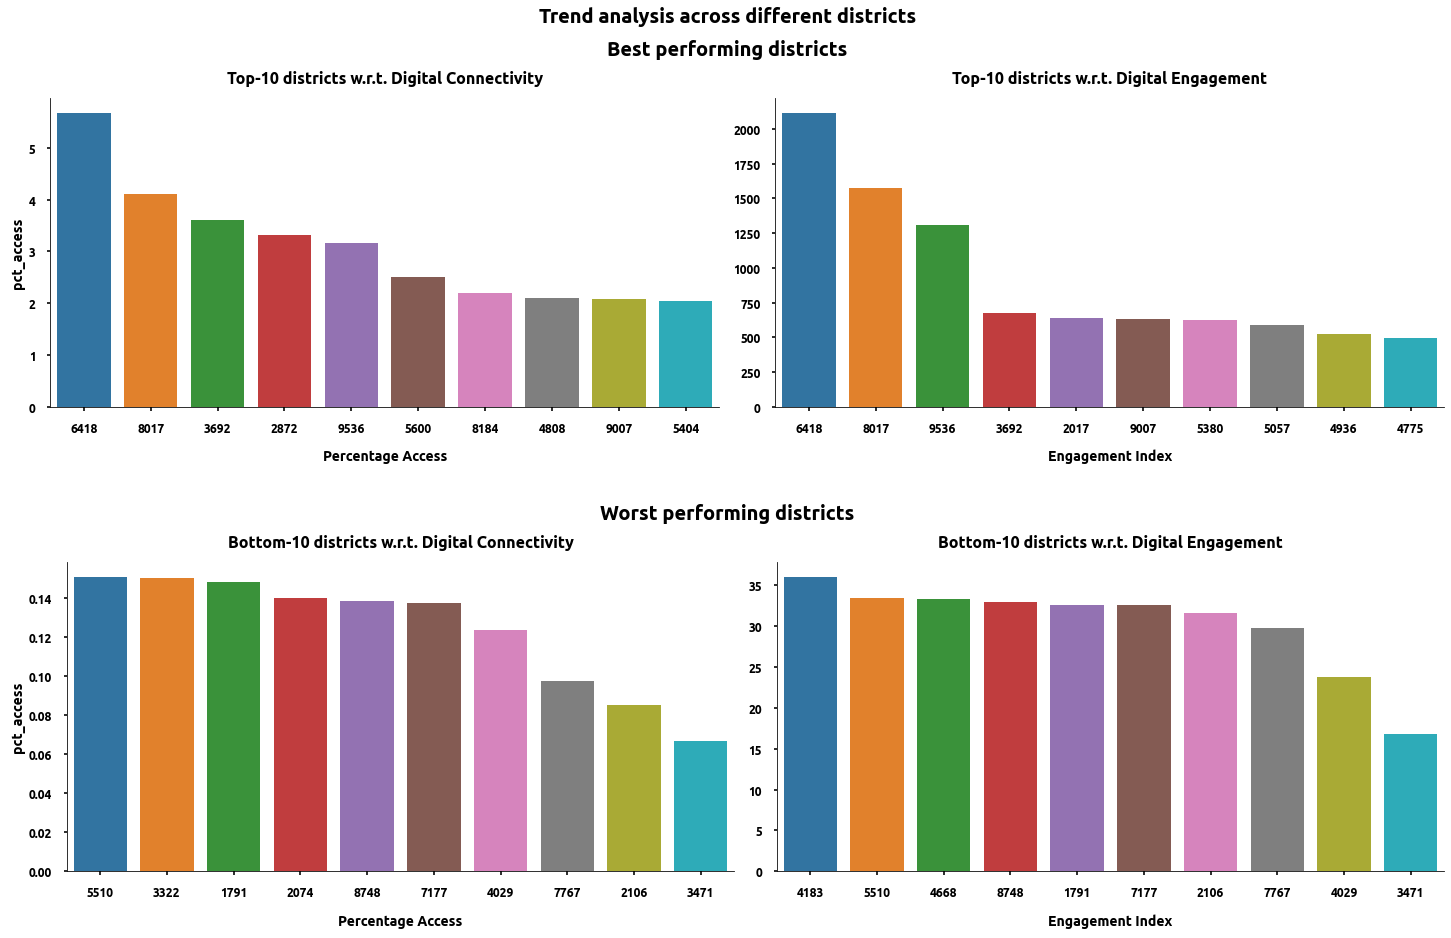

In [25]:
tmp = df.groupby(['district_id'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

fig = plt.figure(figsize=(20, 12), constrained_layout=True)
fig.suptitle('Trend analysis across different districts',
             y=1.07, fontweight='bold')

subfigs = fig.subfigures(nrows=2, ncols=1, wspace=0.15, hspace=0.15)
for row, subfig in enumerate(subfigs):
    if row==0:
        subfig.suptitle("Best performing districts", y=1.07, fontweight='bold')

        ax = subfig.subplots(nrows=1, ncols=2)
        sns.barplot(y='pct_access', x='district_id', ax=ax[0], data=tmp, 
                    order=tmp.sort_values(by='pct_access', ascending=False).head(10)['district_id'])
        ax[0].set_title("Top-10 districts w.r.t. Digital Connectivity", pad=15)
        ax[0].set_xlabel("Percentage Access", labelpad=15)

        sns.barplot(y='engagement_index', x='district_id', ax=ax[1], data=tmp, 
                    order=tmp.sort_values(by='engagement_index', ascending=False).head(10)['district_id'])
        ax[1].set_title("Top-10 districts w.r.t. Digital Engagement", pad=15)
        ax[1].set_xlabel("Engagement Index", labelpad=15)
        ax[1].set(ylabel=None)
    
    else:
        subfig.suptitle("Worst performing districts", y=1.07, fontweight='bold')

        ax = subfig.subplots(nrows=1, ncols=2)
        sns.barplot(y='pct_access', x='district_id', ax=ax[0], data=tmp, 
                    order=tmp.sort_values(by='pct_access', ascending=False).tail(10)['district_id'])
        ax[0].set_title("Bottom-10 districts w.r.t. Digital Connectivity", pad=15)
        ax[0].set_xlabel("Percentage Access", labelpad=15)

        sns.barplot(y='engagement_index', x='district_id', ax=ax[1], data=tmp, 
                    order=tmp.sort_values(by='engagement_index', ascending=False).tail(10)['district_id'])
        ax[1].set_title("Bottom-10 districts w.r.t. Digital Engagement", pad=15)
        ax[1].set_xlabel("Engagement Index", labelpad=15)
        ax[1].set(ylabel=None)

**Observations**

* Districts **6418** and **8017** had the **highest digital connectivity and engagement**
* District **3471** had the **lowest digital connectivity and engagement**

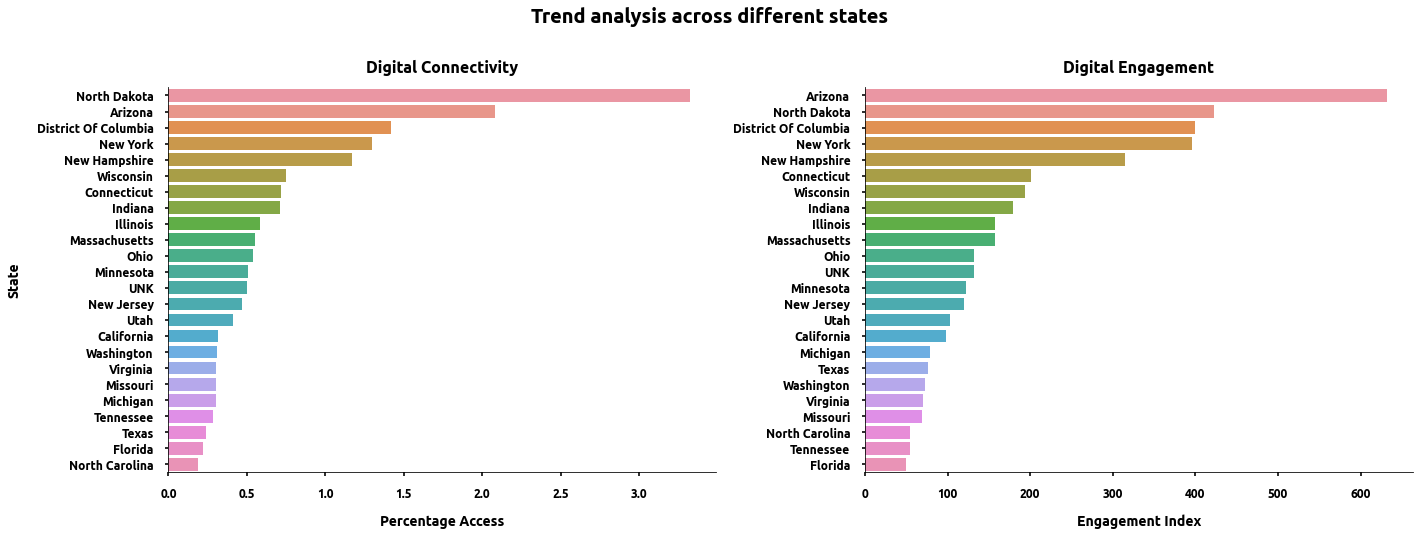

In [26]:
tmp = df.groupby(['state'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(x='pct_access', y='state', ax=ax[0], data=tmp, 
            order=tmp.sort_values(by='pct_access', ascending=False)['state'])
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Percentage Access", labelpad=15)
ax[0].set_ylabel("State", labelpad=15)

sns.barplot(x='engagement_index', y='state', ax=ax[1], data=tmp,
            order=tmp.sort_values(by='engagement_index', ascending=False)['state'])
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Engagement Index", labelpad=15)
ax[1].set(ylabel=None)

fig.tight_layout()
plt.suptitle("Trend analysis across different states", 
             y=1.07, fontweight='bold');

**Observations**

* **Noth Dakota** and **Arizona** had the **highest digital connectivity and engagement**
* **North Carolina** had the **lowest digital connectivity**, while **Florida** had the **lowest digital engagement**

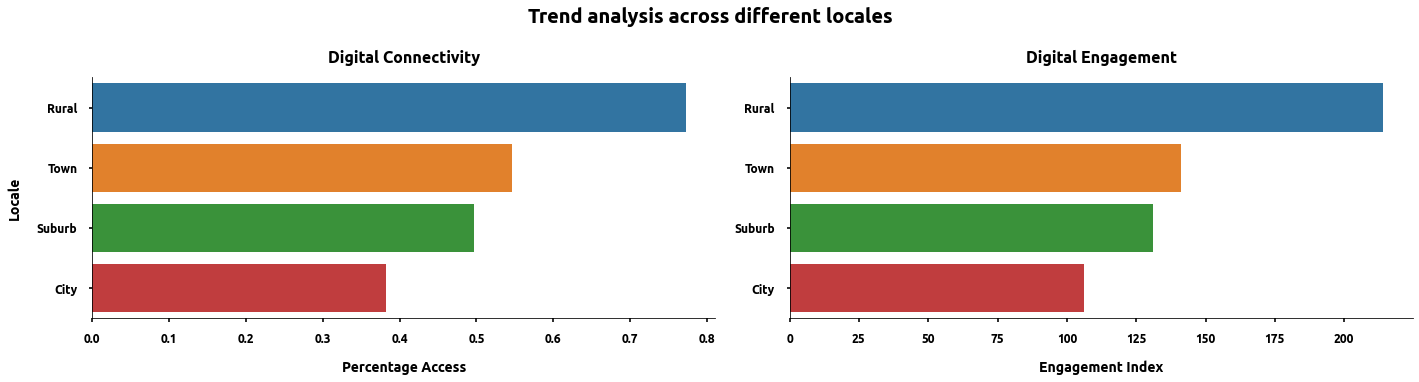

In [27]:
tmp = df[df['locale']!='UNK']\
        .groupby(['locale'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x='pct_access', y='locale', ax=ax[0], data=tmp, 
            order=tmp.sort_values(by='pct_access', ascending=False)['locale'])
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Percentage Access", labelpad=15)
ax[0].set_ylabel("Locale", labelpad=15)

sns.barplot(x='engagement_index', y='locale', ax=ax[1], data=tmp,
            order=tmp.sort_values(by='engagement_index', ascending=False)['locale'])
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Engagement Index", labelpad=15)
ax[1].set(ylabel=None)

fig.tight_layout()
plt.suptitle("Trend analysis across different locales", 
             y=1.07, fontweight='bold');

**Observations**

* **Rural** geography had the **highest digital connectivity and engagement**, while **Cities** had the **lowest digital connectivity and engagement**

### Trend analysis across different racial demographics

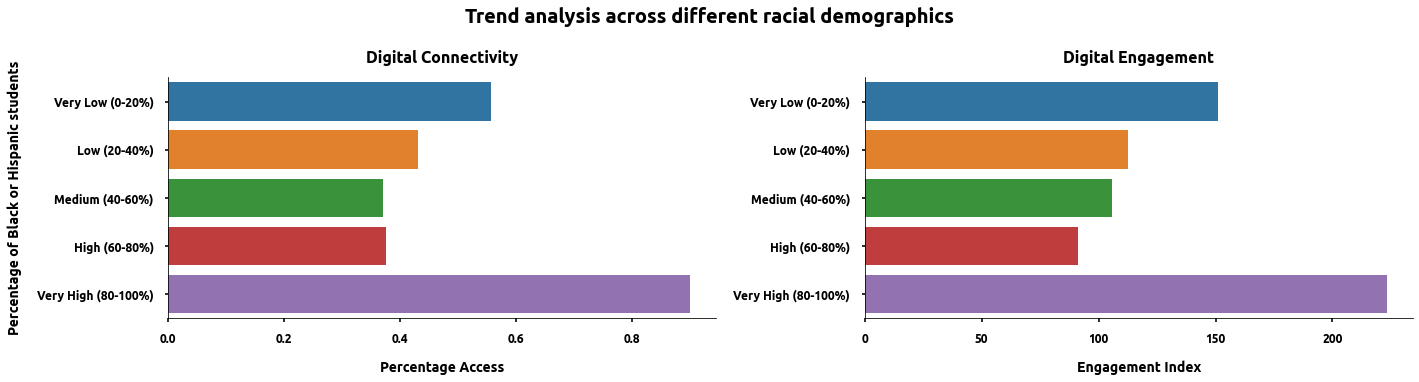

In [28]:
tmp = df[df['pct_black/hispanic']!='UNK']\
        .groupby(['pct_black/hispanic'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp['pct_black/hispanic'] = tmp['pct_black/hispanic'].map({
    '[0, 0.2[': 'Very Low (0-20%)', 
    '[0.2, 0.4[': 'Low (20-40%)', 
    '[0.4, 0.6[': 'Medium (40-60%)', 
    '[0.6, 0.8[': 'High (60-80%)', 
    '[0.8, 1[': 'Very High (80-100%)'
})

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x='pct_access', y='pct_black/hispanic', ax=ax[0], data=tmp)
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Percentage Access", labelpad=15)
ax[0].set_ylabel("Percentage of Black or Hispanic students", labelpad=15)

sns.barplot(x='engagement_index', y='pct_black/hispanic', ax=ax[1], data=tmp)
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Engagement Index", labelpad=15)
ax[1].set(ylabel=None)

fig.tight_layout()
plt.suptitle("Trend analysis across different racial demographics", 
             y=1.07, fontweight='bold');

**Observations**

* Districts with **very high (80-100%)** percentage of black/hispanic students had the **highest digital connectivity and engagement**
* Districts with **very low (0-20%)** percentage of black/hispanic students had the **second highest digital connectivity and engagement**

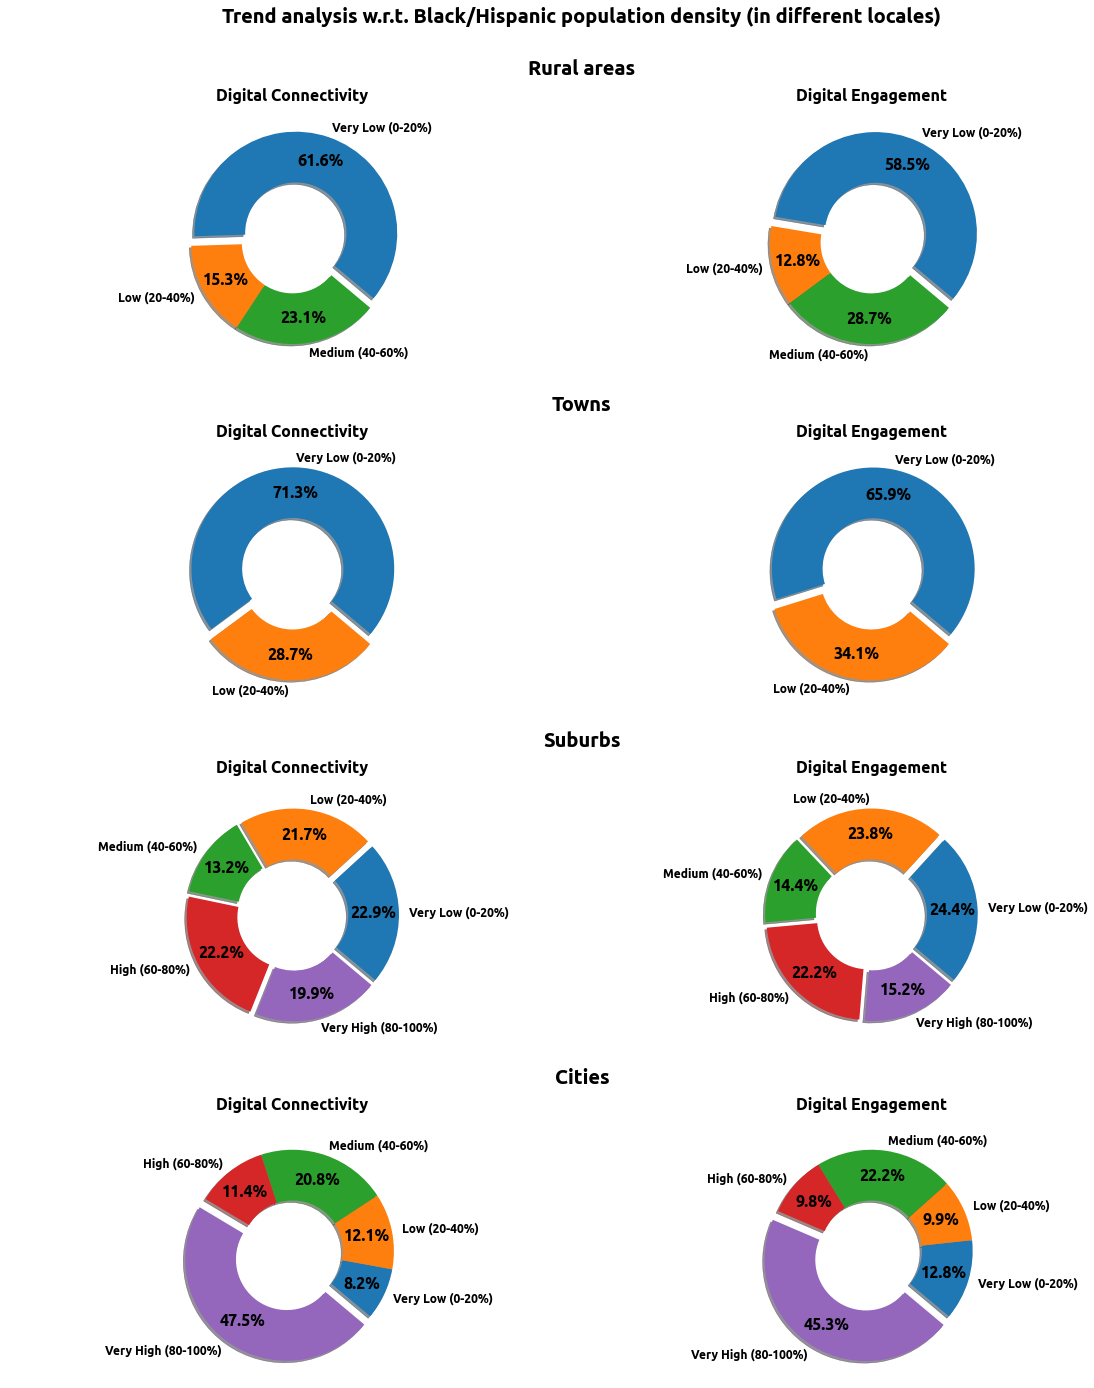

In [29]:
tmp = df[df['pct_black/hispanic']!='UNK']\
        .groupby(['locale','pct_black/hispanic'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp['pct_black/hispanic'] = tmp['pct_black/hispanic'].map({
    '[0, 0.2[': 'Very Low (0-20%)', 
    '[0.2, 0.4[': 'Low (20-40%)', 
    '[0.4, 0.6[': 'Medium (40-60%)', 
    '[0.6, 0.8[': 'High (60-80%)', 
    '[0.8, 1[': 'Very High (80-100%)'
})


fig = plt.figure(figsize=(16, 18), constrained_layout=True)
fig.suptitle('Trend analysis w.r.t. Black/Hispanic population density (in different locales)',
             y=1.06, fontweight='bold')

subfigs = fig.subfigures(nrows=4, ncols=1, wspace=0.15, hspace=0.15)
for row, subfig in enumerate(subfigs):
    if row==0:
        title='Rural areas'
        cat_filter='Rural'
        normalize=None
        expld = (0.1, 0, 0)
    elif row==1:
        title='Towns'
        cat_filter='Town'
        normalize=True
        expld = (0.1, 0)
    elif row==2:
        title='Suburbs'
        cat_filter='Suburb'
        normalize=None
        expld = (0.05, 0.05, 0.05, 0.05, 0.05)
    elif row==3:
        title='Cities'
        cat_filter='City'
        normalize=None
        expld = (0, 0, 0, 0, 0.1)
    
    subfig.suptitle(title, y=1.09, fontweight='bold')

    ax = subfig.subplots(nrows=1, ncols=2)
    ax[0].pie(tmp[tmp['locale']==cat_filter]['pct_access'], 
              labels=tmp[tmp['locale']==cat_filter]['pct_black/hispanic'], 
              labeldistance=1.1, wedgeprops=dict(width=0.5), shadow=True, normalize=normalize,
              autopct='%1.1f%%', pctdistance=0.75, startangle=-40, explode=expld)
    ax[0].set_title("Digital Connectivity", pad=15)

    ax[1].pie(tmp[tmp['locale']==cat_filter]['engagement_index'], 
              labels=tmp[tmp['locale']==cat_filter]['pct_black/hispanic'], 
              labeldistance=1.1, wedgeprops=dict(width=0.5), shadow=True, 
              autopct='%1.1f%%', pctdistance=0.75, startangle=-40, explode=expld)
    ax[1].set_title("Digital Engagement", pad=15)

**Observations**

* In **rural areas** and **towns**, districts with **very low black/hispanic population density** had the highest digital connectivity and engagement
* In **suburbs**, there was an equal distribution of digital connectivity and engagement across different **black/hispanic population densities**
* In **cities**, districts with **very high black/hispanic population density** had the highest digital connectivity and engagement

### Trend analysis across different socio-economic demographics

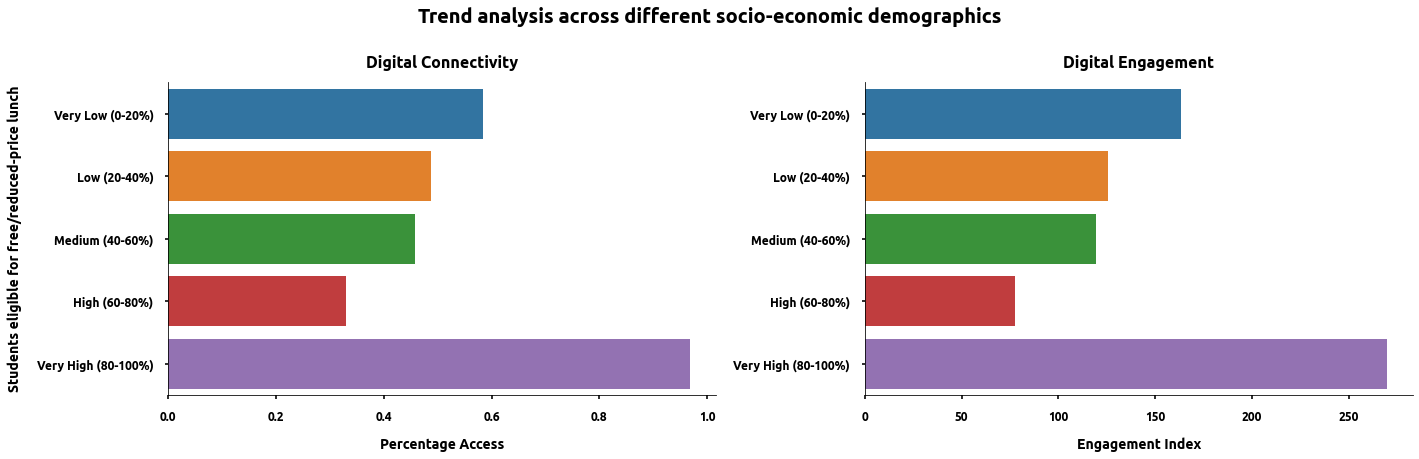

In [30]:
tmp = df[df['pct_free/reduced']!='UNK']\
        .groupby(['pct_free/reduced'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp['pct_free/reduced'] = tmp['pct_free/reduced'].map({
    '[0, 0.2[': 'Very Low (0-20%)', 
    '[0.2, 0.4[': 'Low (20-40%)', 
    '[0.4, 0.6[': 'Medium (40-60%)', 
    '[0.6, 0.8[': 'High (60-80%)', 
    '[0.8, 1[': 'Very High (80-100%)'
})

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x='pct_access', y='pct_free/reduced', ax=ax[0], data=tmp)
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Percentage Access", labelpad=15)
ax[0].set_ylabel("Students eligible for free/reduced-price lunch", labelpad=15)

sns.barplot(x='engagement_index', y='pct_free/reduced', ax=ax[1], data=tmp)
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Engagement Index", labelpad=15)
ax[1].set(ylabel=None)

fig.tight_layout()
plt.suptitle("Trend analysis across different socio-economic demographics", 
             y=1.07, fontweight='bold');

**Observations**

* Districts with **very high (80-100%)** percentage of students eligible for free or reduced-price lunch had the **highest digital connectivity and engagement**

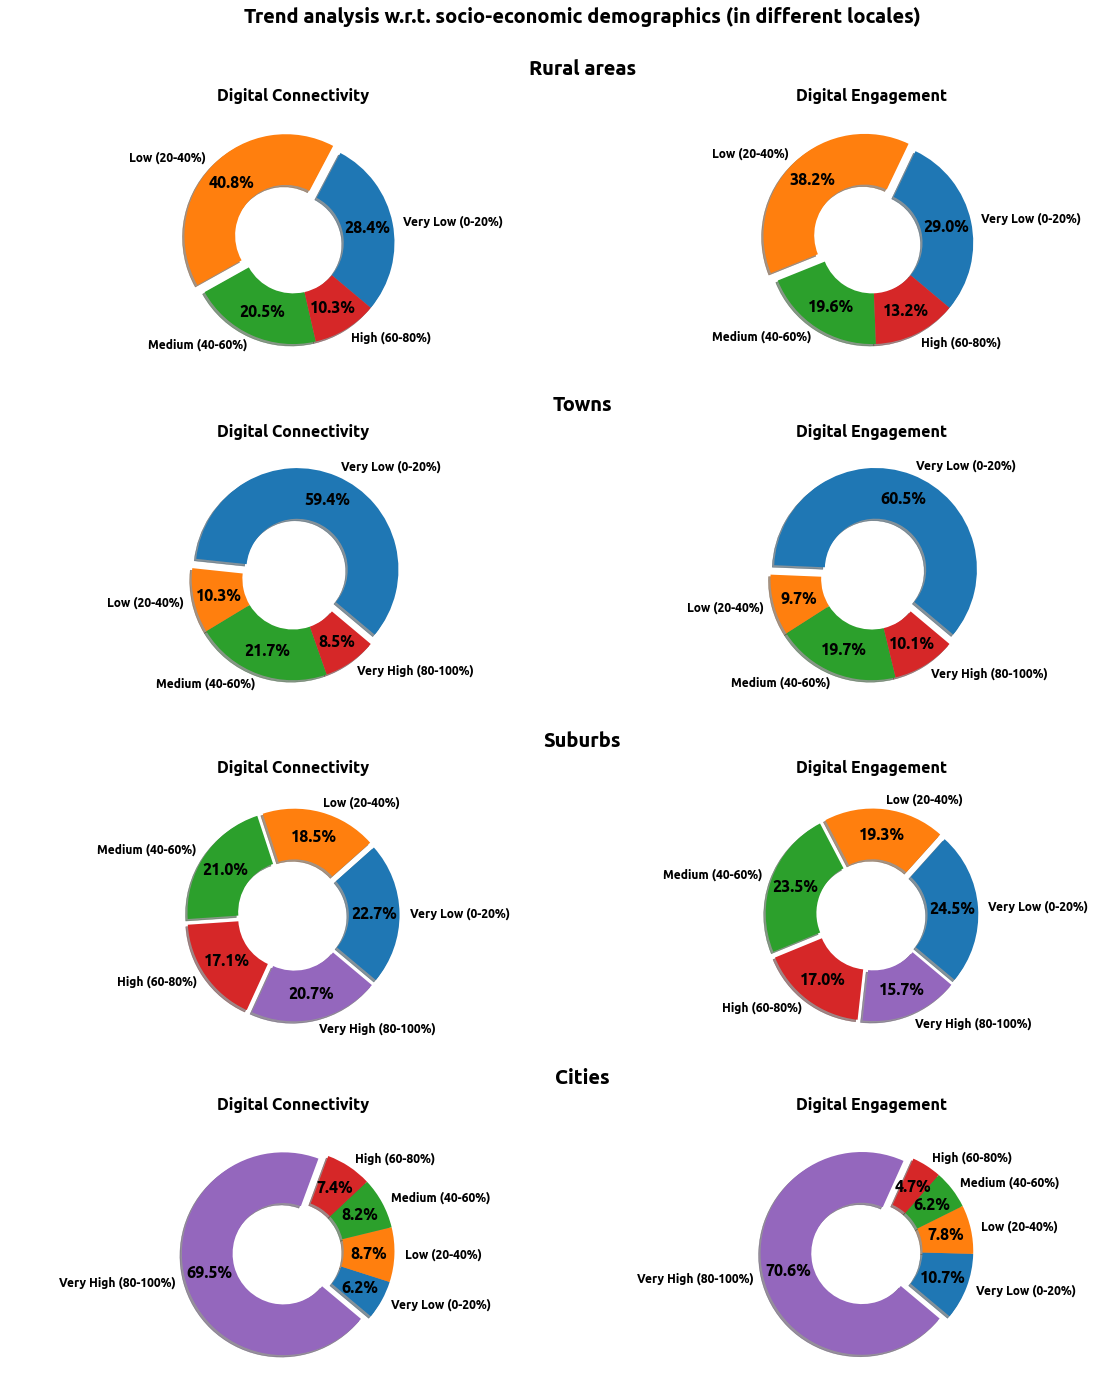

In [31]:
tmp = df[df['pct_free/reduced']!='UNK']\
        .groupby(['locale','pct_free/reduced'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp['pct_free/reduced'] = tmp['pct_free/reduced'].map({
    '[0, 0.2[': 'Very Low (0-20%)', 
    '[0.2, 0.4[': 'Low (20-40%)', 
    '[0.4, 0.6[': 'Medium (40-60%)', 
    '[0.6, 0.8[': 'High (60-80%)', 
    '[0.8, 1[': 'Very High (80-100%)'
})


fig = plt.figure(figsize=(16, 18), constrained_layout=True)
fig.suptitle('Trend analysis w.r.t. socio-economic demographics (in different locales)',
             y=1.06, fontweight='bold')

subfigs = fig.subfigures(nrows=4, ncols=1, wspace=0.15, hspace=0.15)
for row, subfig in enumerate(subfigs):
    if row==0:
        title='Rural areas'
        cat_filter='Rural'
        expld = (0, 0.1, 0, 0)
    elif row==1:
        title='Towns'
        cat_filter='Town'
        expld = (0.1, 0, 0, 0)
    elif row==2:
        title='Suburbs'
        cat_filter='Suburb'
        expld = (0.05, 0.05, 0.05, 0.05, 0.05)
    elif row==3:
        title='Cities'
        cat_filter='City'
        expld = (0, 0, 0, 0, 0.1)
    
    subfig.suptitle(title, y=1.09, fontweight='bold')

    ax = subfig.subplots(nrows=1, ncols=2)
    ax[0].pie(tmp[tmp['locale']==cat_filter]['pct_access'], 
              labels=tmp[tmp['locale']==cat_filter]['pct_free/reduced'], 
              labeldistance=1.1, wedgeprops=dict(width=0.5), shadow=True, 
              autopct='%1.1f%%', pctdistance=0.75, startangle=-40, explode=expld)
    ax[0].set_title("Digital Connectivity", pad=15)

    ax[1].pie(tmp[tmp['locale']==cat_filter]['engagement_index'], 
              labels=tmp[tmp['locale']==cat_filter]['pct_free/reduced'], 
              labeldistance=1.1, wedgeprops=dict(width=0.5), shadow=True, 
              autopct='%1.1f%%', pctdistance=0.75, startangle=-40, explode=expld)
    ax[1].set_title("Digital Engagement", pad=15)

**Observations**

* In **rural areas**, districts with **low student ratio (20-40%) eligible for free/reduced-price lunch** had the highest digital connectivity and engagement
* In **towns**, districts with **very low student ratio (0-20%) eligible for free/reduced-price lunch** had the highest digital connectivity and engagement
* In **suburbs**, there was an equal distribution of digital connectivity and engagement across different **socio-enonomic demographics**
* In **cities**, districts with **very high student ratio (80-100%) eligible for free/reduced-price lunch** had the highest digital connectivity and engagement

### Trend analysis across different internet-accessibility demographics

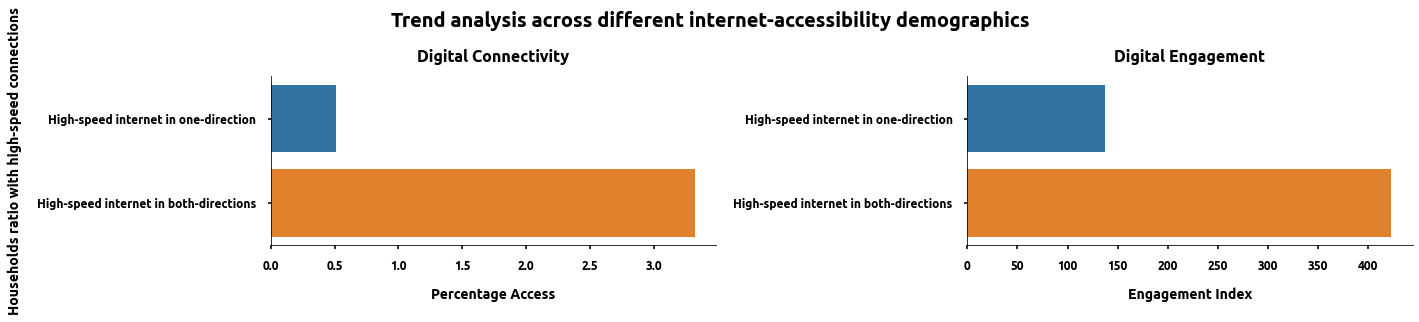

In [32]:
tmp = df[df['county_connections_ratio']!='UNK']\
        .groupby(['county_connections_ratio'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

tmp['county_connections_ratio'] = tmp['county_connections_ratio'].map({
    '[0.18, 1[': 'High-speed internet in one-direction', 
    '[1, 2[': 'High-speed internet in both-directions'
})

fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.barplot(x='pct_access', y='county_connections_ratio', ax=ax[0], data=tmp)
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Percentage Access", labelpad=15)
ax[0].set_ylabel("Households ratio with high-speed connections", labelpad=15)

sns.barplot(x='engagement_index', y='county_connections_ratio', ax=ax[1], data=tmp)
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Engagement Index", labelpad=15)
ax[1].set(ylabel=None)

fig.tight_layout()
plt.suptitle("Trend analysis across different internet-accessibility demographics", 
             y=1.07, fontweight='bold');

**Observations**

* Households with **high-speed connections in both directions** had the **highest digital connectivity and engagement**

### Trend analysis w.r.t. per-pupil expenditure

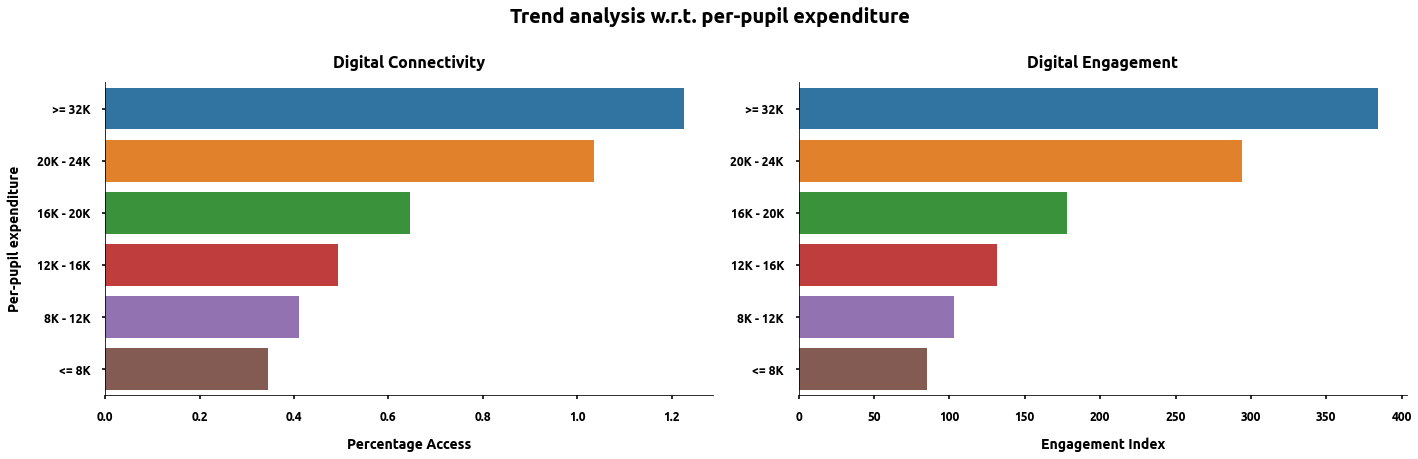

In [33]:
tmp = df[df['pp_expenditure_group']!='UNK']\
        .groupby(['pp_expenditure_group'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x='pct_access', y='pp_expenditure_group', ax=ax[0], data=tmp,
            order=tmp.sort_values(by='pct_access', ascending=False)['pp_expenditure_group'])
ax[0].set_title("Digital Connectivity", pad=15)
ax[0].set_xlabel("Percentage Access", labelpad=15)
ax[0].set_ylabel("Per-pupil expenditure", labelpad=15)

sns.barplot(x='engagement_index', y='pp_expenditure_group', ax=ax[1], data=tmp,
            order=tmp.sort_values(by='engagement_index', ascending=False)['pp_expenditure_group'])
ax[1].set_title("Digital Engagement", pad=15)
ax[1].set_xlabel("Engagement Index", labelpad=15)
ax[1].set(ylabel=None)

fig.tight_layout()
plt.suptitle("Trend analysis w.r.t. per-pupil expenditure", 
             y=1.07, fontweight='bold');

**Observations**

* Demographics with **per-pupil expenditure greater than 32000** had the **highest digital connectivity and engagement**
* Demographics with **per-pupil expenditure less than 8000** had the **lowest digital connectivity and engagement**

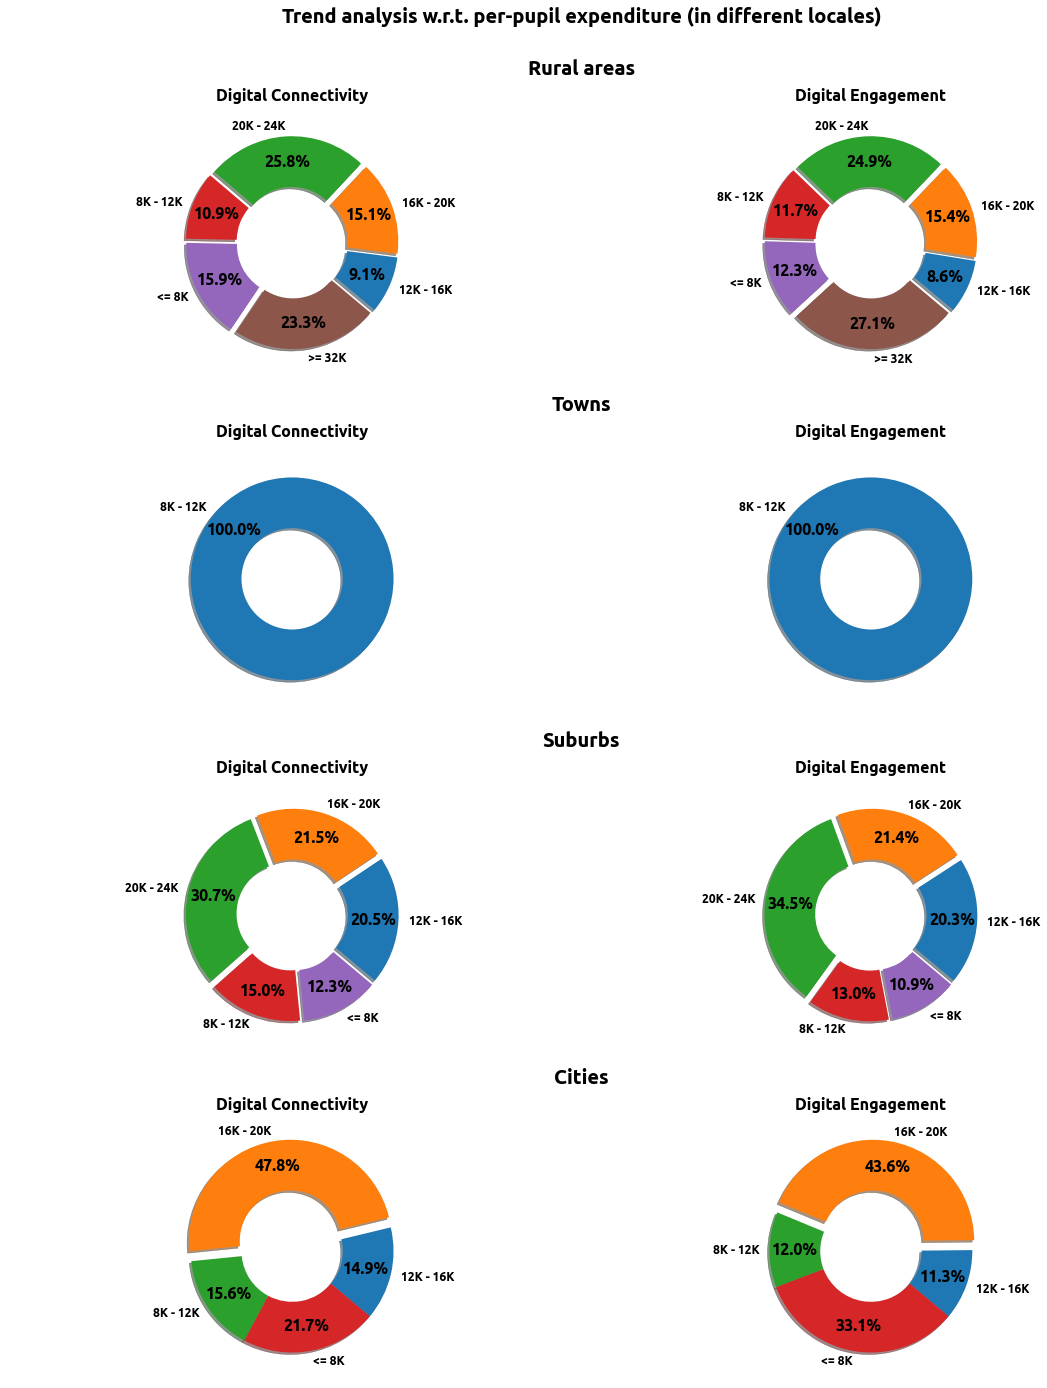

In [34]:
tmp = df[df['pp_expenditure_group']!='UNK']\
        .groupby(['locale','pp_expenditure_group'])\
        .agg({'engagement_index':'mean', 'pct_access':'mean'})\
        .reset_index()\
        .copy()

fig = plt.figure(figsize=(16, 18), constrained_layout=True)
fig.suptitle('Trend analysis w.r.t. per-pupil expenditure (in different locales)',
             y=1.06, fontweight='bold')

subfigs = fig.subfigures(nrows=4, ncols=1, wspace=0.15, hspace=0.15)
for row, subfig in enumerate(subfigs):
    if row==0:
        title='Rural areas'
        cat_filter='Rural'
        normalize=None
        expld = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
    elif row==1:
        title='Towns'
        cat_filter='Town'
        normalize=True
        expld = None
    elif row==2:
        title='Suburbs'
        cat_filter='Suburb'
        normalize=None
        expld = (0.05, 0.05, 0.05, 0.05, 0.05)
    elif row==3:
        title='Cities'
        cat_filter='City'
        normalize=None
        expld = (0, 0.1, 0, 0)
    
    subfig.suptitle(title, y=1.09, fontweight='bold')

    ax = subfig.subplots(nrows=1, ncols=2)
    ax[0].pie(tmp[tmp['locale']==cat_filter]['pct_access'], 
              labels=tmp[tmp['locale']==cat_filter]['pp_expenditure_group'], 
              labeldistance=1.1, wedgeprops=dict(width=0.5), shadow=True, normalize=normalize,
              autopct='%1.1f%%', pctdistance=0.75, startangle=-40, explode=expld)
    ax[0].set_title("Digital Connectivity", pad=15)

    ax[1].pie(tmp[tmp['locale']==cat_filter]['engagement_index'], 
              labels=tmp[tmp['locale']==cat_filter]['pp_expenditure_group'], 
              labeldistance=1.1, wedgeprops=dict(width=0.5), shadow=True, 
              autopct='%1.1f%%', pctdistance=0.75, startangle=-40, explode=expld)
    ax[1].set_title("Digital Engagement", pad=15)

**Observations**

* In **rural areas** and **suburbs**, there was an equal distribution of digital connectivity and engagement across different **per-pupil expenditures**
* In **towns**, there's only one demographic of **per-pupil expenditures less than 8000**
* In **cities**, demographics with **per-pupil expenditures between 16000 and 20000** had the highest digital connectivity and engagement